# 03 Experiments with pre-defined splits

One of the benefits of the disjoint generative models approach, is the ability to use different models for different subsets of the data. For example using a model that is good for nummerical attributes to model those variables and using a model that is good for categorical attributes for them.

In the following we will show how this can be done to the benefit of the synthetic data quality. 

The example will be based on the Hepatitis dataset from the UCI repository. The dataset contains ~1300 rows and 29 columns. The columns are a mix of categorical and numerical attributes. The dataset contains no missing values. We report the average metric result and standard error of the mean for 10 repeated rund of the experiment with 80% of the data used for training and 20% for the metrics that require holdout data.

In [2]:
### Imports
import pandas as pd

from pandas import DataFrame
from typing import List, Dict

from joblib import Parallel, delayed

from syntheval import SynthEval

from sklearn.ensemble import RandomForestClassifier
from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator
from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

### Constants
NUM_REPS = 10

### Metrics
metrics = {
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff" : {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia_risk"  : {"num_eval_iter": 5},
}

In [3]:
### Load training and testing datasets and define categorical and numerical attributes

df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

print(cat_atts)
print(num_atts)

df_train.head()

['WBC', 'RBC', 'Plat', 'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF', 'Gender', 'Fever', 'Nausea/Vomting', 'Headache', 'Diarrhea', 'Fatigue & generalized bone ache', 'Jaundice', 'Epigastric pain', 'b_class']
['Age', 'BMI', 'HGB', 'AST 1', 'ALT 1', 'ALT 4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w', 'Baseline histological Grading']


,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,b_class
0,47,2,32,2,2,1,2,2,2,2,...,87,56,39,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",11,1
1,36,2,24,2,1,2,2,2,1,2,...,108,74,45,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",3,1
2,50,1,34,1,1,2,1,2,2,2,...,71,125,28,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",9,1
3,32,2,30,1,2,1,2,2,1,1,...,102,84,40,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",6,0
4,58,1,29,2,2,1,1,2,2,1,...,55,40,40,"(5, 1201086]","(5, 1201715]","(0, 5]","(0, 5]","(0, 5]",15,1


In [11]:
### Background measurement
SE = SynthEval(df_train, df_test, verbose=False)
SE.evaluate(df_train, analysis_target_var=label,**metrics)

,metric,dim,val,err,n_val,n_err
0,corr_mat_diff,u,0.000000,NaN,1.000000,NaN
1,auroc,u,0.000000,NaN,1.000000,NaN
2,cls_F1_diff,u,0.000000,0.007357,1.000000,0.007357
3,cls_F1_diff_hout,u,0.000000,0.000000,1.000000,0.000000
4,eps_identif_risk,p,0.000000,NaN,1.000000,NaN
5,priv_loss_eps,p,-0.209050,NaN,0.790950,NaN
6,median_DCR,p,1.000000,NaN,0.761594,NaN
7,mia_cls_risk,p,0.333333,0.000000,0.666667,0.000000


In [ ]:

def model_experiment(df_train: DataFrame, df_test: DataFrame, label: str, model: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of a generative model on the same 
    dataset and return best estimate of the mean of the various metrics. 
    """
    SE = SynthEval(df_train, df_test, verbose=False)

    dfs_list = Parallel(n_jobs=-1)(delayed(generate_synthetic_data)(df_train, model, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}
    
    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
cart_results = model_experiment(df_train, df_test, label, 'synthpop', metrics)
cart_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop.csv')

In [ ]:
bn_results = model_experiment(df_train, df_test, label, 'datasynthesizer', metrics)
bn_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer.csv')
#~12 mins

================ Constructing Bayesian Network (BN) ================
Adding ROOT Baseline histological Grading
Adding attribute ALT 24
Adding attribute ALT 4
Adding attribute ALT 1
Adding attribute ALT 12
Adding attribute AST 1
Adding attribute Age
Adding attribute ALT 36
Adding attribute ALT 48
Adding attribute BMI
Adding attribute ALT after 24 w
Adding attribute HGB
Adding attribute WBC
Adding attribute Plat
Adding attribute Fatigue & generalized bone ache
Adding attribute Jaundice
Adding attribute Headache
Adding attribute Diarrhea
Adding attribute Fever
Adding attribute Epigastric pain
Adding attribute Gender
Adding attribute Nausea/Vomting
Adding attribute RNA EF
Adding attribute RNA EOT
Adding attribute RNA 12
Adding attribute b_class
Adding attribute RBC
Adding attribute RNA 4
Adding attribute RNA Base
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT Nausea/Vomting
Adding attribu

/tmp/ipykernel_3361653/365658777.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res = res.drop(columns=['rank', 'u_rank', 'p_rank'])


In [ ]:
ctgan_results = model_experiment(df_train, df_test, label, 'ctgan', metrics)
ctgan_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/ctgan.csv')
#~79 mins

[2024-12-16T14:40:11.393622+0100][2982803][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
 37%|███▋      | 749/2000 [07:29<12:30,  1.67it/s]
[2024-12-16T14:47:45.929537+0100][2982803][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
 27%|██▋       | 549/2000 [05:47<15:18,  1.58it/s]
[2024-12-16T14:53:37.714040+0100][2982803][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|███▍      | 699/2000 [07:33<14:03,  1.54it/s]
[2024-12-16T15:01:15.901379+0100][2982803][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
 37%|███▋      | 749/2000 [08:06<13:32,  1.54it/s]
[2024-12-16T15:09:28.623247+0100][2982803][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/g

In [ ]:
adsgan_results = model_experiment(df_train, df_test, label, 'adsgan', metrics)
adsgan_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/adsgan.csv')
#~73 mins

/home/lautrup/sdg_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-12-17T10:11:30.061177+0100][3361653][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
  5%|▌         | 549/10000 [06:02<1:44:07,  1.51it/s]
[2024-12-17T10:17:36.999565+0100][3361653][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|▋         | 699/10000 [07:49<1:44:08,  1.49it/s]
[2024-12-17T10:25:28.322708+0100][3361653][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
  6%|▋         | 649/10000 [07:16<1:44:46,  1.49it/s]
[2024-12-17T10:32:46.358257+0100][3361653][CRITICAL] module disabled: /home/lautrup/sdg_en

In [7]:
dpgan_results = model_experiment(df_train, df_test, label, 'dpgan', metrics)
dpgan_results.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/dpgan.csv')

[2024-12-17T11:29:26.027203+0100][3477488][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T11:29:26.048782+0100][3477484][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T11:29:26.114987+0100][3477493][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T11:29:26.157315+0100][3477483][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T11:29:26.201456+0100][3477491][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T11:29:26.204427+0100][3477490][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T11:2

### Now do the many combinations of mixed models
We use synthpop and DataSynthesizer for the categorical attributes and CTGAN, ADSGAN and DPGAN for the nummerical attributes.

In [17]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """
    Rf = RandomForestClassifier(n_estimators=100)
    JS = UsingJoiningValidator(JoiningValidator(Rf, verbose=False), patience=5)

    dgms = DisjointGenerativeModels(df_train, gms, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 8    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = {model1: cat_atts, model2: num_atts}
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop_ctgan.csv')
#~12 mins

Cross-validated accuracies: [0.5957767722473605, 0.5610859728506787, 0.5776772247360482, 0.5867269984917044, 0.5776772247360482]
Mean accuracy: 0.579788838612368
Cross-validated accuracies: [0.5912518853695324, 0.5912518853695324, 0.5882352941176471, 0.5610859728506787, 0.5972850678733032]
Mean accuracy: 0.5858220211161387
Cross-validated accuracies: [0.5852187028657617, 0.579185520361991, 0.5972850678733032, 0.5806938159879337, 0.5625942684766214]
Mean accuracy: 0.5809954751131222
Cross-validated accuracies: [0.5806938159879337, 0.5731523378582202, 0.5656108597285068, 0.5822021116138764, 0.6078431372549019]
Mean accuracy: 0.5819004524886877
Cross-validated accuracies: [0.5686274509803921, 0.5822021116138764, 0.5882352941176471, 0.5731523378582202, 0.5701357466063348]
Mean accuracy: 0.5764705882352941
Cross-validated accuracies: [0.5776772247360482, 0.5867269984917044, 0.5897435897435898, 0.5761689291101055, 0.5942684766214178]
Mean accuracy: 0.5849170437405731
Cross-validated accuraci

Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.



Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, 

Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.

Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_90_synthpop.txt 
Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthpop_temp_60_synthpop.txt 
Synthetic data exported as csv file(s).
Information on synthet

[2024-12-17T12:42:57.029276+0100][3545405][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T12:42:57.048493+0100][3545338][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T12:42:57.079068+0100][3545339][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T12:42:57.105096+0100][3545408][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T12:42:57.165188+0100][3545404][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T12:42:57.350233+0100][3545337][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T12:4

Predicted good joins fraction: 0.019909502262443438
Predicted good joins fraction: 0.019159741458910435


 36%|███▋      | 725/2000 [06:05<09:34,  2.22it/s]

Predicted good joins fraction: 0.017180513061896916
Predicted good joins fraction: 0.013769157088122605
Predicted good joins fraction: 0.014689814252761928
Predicted good joins fraction: 0.013799901429275506


 36%|███▋      | 726/2000 [06:05<09:24,  2.26it/s]

Predicted good joins fraction: 0.01461769115442279
Predicted good joins fraction: 0.01103081019399011
Predicted good joins fraction: 0.011282051282051283
Predicted good joins fraction: 0.010762448132780083
Predicted good joins fraction: 0.011797090051120724


 36%|███▋      | 725/2000 [06:04<09:06,  2.33it/s]

Predicted good joins fraction: 0.010744130521289296
Predicted good joins fraction: 0.01032448377581121
Predicted good joins fraction: 0.010432190760059613


 36%|███▌      | 720/2000 [06:05<07:08,  2.99it/s]

Predicted good joins fraction: 0.009720700985761227
Predicted good joins fraction: 0.006912760956726116
Predicted good joins fraction: 0.007517750243630795


 36%|███▌      | 721/2000 [06:05<07:20,  2.90it/s]

Predicted good joins fraction: 0.00855659980361902
Predicted good joins fraction: 0.009054895302773062
Predicted good joins fraction: 0.007138777841233581


 36%|███▋      | 727/2000 [06:05<09:12,  2.30it/s]

Predicted good joins fraction: 0.006902502157031924
Predicted good joins fraction: 0.0076744859542426875
Predicted good joins fraction: 0.004961330804027433


 37%|███▋      | 733/2000 [06:06<09:05,  2.32it/s]

Predicted good joins fraction: 0.005572664613579704
Predicted good joins fraction: 0.007815956348621146
Predicted good joins fraction: 0.010552913198573127


 36%|███▌      | 721/2000 [06:05<09:47,  2.18it/s]

Predicted good joins fraction: 0.006609583896650143
Predicted good joins fraction: 0.005897474671102374
Predicted good joins fraction: 0.0060845756008518406


 36%|███▌      | 724/2000 [06:06<07:28,  2.85it/s]

Predicted good joins fraction: 0.006427915518824609
Predicted good joins fraction: 0.0038508934072704866
Predicted good joins fraction: 0.00463893613731251


 36%|███▌      | 722/2000 [06:06<10:08,  2.10it/s]

Predicted good joins fraction: 0.006524778623582414
Predicted good joins fraction: 0.004847537138389367
Predicted good joins fraction: 0.006599622878692646


 38%|███▊      | 755/2000 [06:07<12:01,  1.73it/s]

Predicted good joins fraction: 0.005536222714330908
Predicted good joins fraction: 0.004930809607125815
Predicted good joins fraction: 0.004635549872122762


 37%|███▋      | 732/2000 [06:08<10:24,  2.03it/s]

Predicted good joins fraction: 0.004335956319254858
Predicted good joins fraction: 0.004516129032258065
Predicted good joins fraction: 0.005670771224886585


 36%|███▌      | 724/2000 [06:07<09:21,  2.27it/s]

Predicted good joins fraction: 0.0021182988430829396
Predicted good joins fraction: 0.003919007184846506
Predicted good joins fraction: 0.004754098360655738


 36%|███▌      | 723/2000 [06:07<08:57,  2.37it/s]

Predicted good joins fraction: 0.004282655246252677
Predicted good joins fraction: 0.004301075268817204
Predicted good joins fraction: 0.004485794982555242


 36%|███▋      | 725/2000 [06:07<09:22,  2.27it/s]

Predicted good joins fraction: 0.0043391188251001335
Predicted good joins fraction: 0.003519946362722092
Predicted good joins fraction: 0.002859545836837679


 36%|███▋      | 725/2000 [06:07<10:30,  2.02it/s]

Predicted good joins fraction: 0.004554655870445344
Predicted good joins fraction: 0.004236570072869005
Predicted good joins fraction: 0.0028931245745405037


 36%|███▋      | 726/2000 [06:08<10:13,  2.08it/s]

Predicted good joins fraction: 0.004266939750810718
Predicted good joins fraction: 0.004456633527596846
Predicted good joins fraction: 0.003443526170798898


 37%|███▋      | 738/2000 [06:09<08:35,  2.45it/s]

Predicted good joins fraction: 0.0017277125086385626
Predicted good joins fraction: 0.00380754586362063
Predicted good joins fraction: 0.00330090340514246


 36%|███▋      | 727/2000 [06:08<10:10,  2.09it/s]

Predicted good joins fraction: 0.003660449712393237
Predicted good joins fraction: 0.00244926522043387
Predicted good joins fraction: 0.004209049456331112


 36%|███▋      | 727/2000 [06:09<09:02,  2.35it/s]

Predicted good joins fraction: 0.0033462486791123636
Predicted good joins fraction: 0.0026506449902809685
Predicted good joins fraction: 0.002126151665485471
Predicted good joins fraction: 0.0035511363636363635
Predicted good joins fraction: 0.0024946543121881683
Predicted good joins fraction: 0.002500893176134334


 38%|███▊      | 762/2000 [06:10<08:36,  2.40it/s]

Predicted good joins fraction: 0.002507163323782235
Predicted good joins fraction: 0.002872531418312388
Predicted good joins fraction: 0.003961109110550955


 37%|███▋      | 737/2000 [06:09<08:38,  2.44it/s]

Predicted good joins fraction: 0.0025307302964569776
Predicted good joins fraction: 0.003443276549474447
Predicted good joins fraction: 0.002182214948172395


 36%|███▋      | 729/2000 [06:09<10:33,  2.01it/s]

Predicted good joins fraction: 0.002369236376890833
Predicted good joins fraction: 0.003288271830471319
Predicted good joins fraction: 0.0021994134897360706


 37%|███▋      | 734/2000 [06:10<08:22,  2.52it/s]

Predicted good joins fraction: 0.0016531961792799412
Predicted good joins fraction: 0.0020239190432382705
Predicted good joins fraction: 0.0035029498525073746


 36%|███▋      | 730/2000 [06:10<10:08,  2.09it/s]

Predicted good joins fraction: 0.0018501387604070306
Predicted good joins fraction: 0.004077849860982391
Predicted good joins fraction: 0.0018611576400521124


 37%|███▋      | 735/2000 [06:11<08:25,  2.50it/s]

Predicted good joins fraction: 0.0013052396046988625
Predicted good joins fraction: 0.0020537714712471995
Predicted good joins fraction: 0.0026192703461178674


 37%|███▋      | 731/2000 [06:10<09:56,  2.13it/s]

Predicted good joins fraction: 0.0030013130744700805
Predicted good joins fraction: 0.0037629350893697085
Predicted good joins fraction: 0.0033994334277620396


 38%|███▊      | 766/2000 [06:12<08:19,  2.47it/s]

Predicted good joins fraction: 0.0028425241614553724
Predicted good joins fraction: 0.0028506271379703536
Predicted good joins fraction: 0.002858776443682104


 37%|███▋      | 741/2000 [06:12<09:43,  2.16it/s]

Predicted good joins fraction: 0.0015290519877675841
Predicted good joins fraction: 0.0032542113323124045
Predicted good joins fraction: 0.0019204916458613404


 38%|███▊      | 767/2000 [06:12<08:26,  2.43it/s]

Predicted good joins fraction: 0.00173176832788147
Predicted good joins fraction: 0.0026985350809560524
Predicted good joins fraction: 0.0015461925009663702


 37%|███▋      | 735/2000 [06:12<08:30,  2.48it/s]

Predicted good joins fraction: 0.0029036004645760743
Predicted good joins fraction: 0.0021355076684139
Final size of synthetic data: 3700


 42%|████▏     | 840/2000 [06:45<07:33,  2.56it/s]

Predicted good joins fraction: 0.01911764705882353
Predicted good joins fraction: 0.020989505247376312


 41%|████      | 811/2000 [06:44<08:11,  2.42it/s]

Predicted good joins fraction: 0.017316527270585462
Predicted good joins fraction: 0.016183169503716135


 41%|████      | 818/2000 [06:45<07:55,  2.48it/s]

Predicted good joins fraction: 0.014134275618374558
Predicted good joins fraction: 0.01557285873192436
Predicted good joins fraction: 0.013308223477715004
Predicted good joins fraction: 0.013487721084107392


 42%|████▏     | 842/2000 [06:46<07:32,  2.56it/s]

Predicted good joins fraction: 0.013027215271507804
Predicted good joins fraction: 0.010585467851542081


 41%|████      | 813/2000 [06:45<08:00,  2.47it/s]

Predicted good joins fraction: 0.012019548276317528
Predicted good joins fraction: 0.010561497326203208


 41%|████      | 820/2000 [06:46<07:49,  2.51it/s]

Predicted good joins fraction: 0.009593298202945548
Predicted good joins fraction: 0.007639836289222374


 40%|████      | 800/2000 [06:45<26:29,  1.32s/it]

Predicted good joins fraction: 0.010310695628265053
Predicted good joins fraction: 0.007917766356438394
Predicted good joins fraction: 0.008821058527023242
Predicted good joins fraction: 0.009040824975278994


 41%|████      | 815/2000 [06:46<07:52,  2.51it/s]

Predicted good joins fraction: 0.007840342124019958
Predicted good joins fraction: 0.010057471264367816
Predicted good joins fraction: 0.0059506531204644416


 40%|████      | 800/2000 [06:46<29:53,  1.49s/it]

Predicted good joins fraction: 0.009198423127463863
Predicted good joins fraction: 0.005747126436781609
Predicted good joins fraction: 0.008003557136505114


 42%|████▏     | 846/2000 [06:47<07:28,  2.57it/s]

Predicted good joins fraction: 0.007321081727177648
Predicted good joins fraction: 0.007224563515954244
Predicted good joins fraction: 0.006973923590054579


 40%|████      | 802/2000 [06:47<18:32,  1.08it/s]

Predicted good joins fraction: 0.007022900763358778
Predicted good joins fraction: 0.022171945701357467
Predicted good joins fraction: 0.005535055350553505
Predicted good joins fraction: 0.02163350300786673
Predicted good joins fraction: 0.005875077303648732


 41%|████      | 812/2000 [06:48<08:03,  2.46it/s]

Predicted good joins fraction: 0.006687402799377916
Predicted good joins fraction: 0.016081352725552795
Predicted good joins fraction: 0.006732425238766244
Predicted good joins fraction: 0.01682490085326283
Predicted good joins fraction: 0.004728877679697352


 41%|████▏     | 825/2000 [06:48<07:48,  2.51it/s]

Predicted good joins fraction: 0.01699058794768366
Predicted good joins fraction: 0.005543237250554324
Predicted good joins fraction: 0.016040785874160655
Predicted good joins fraction: 0.004937091893613633


 40%|████      | 807/2000 [06:47<07:42,  2.58it/s]

Predicted good joins fraction: 0.016681410337419437
Predicted good joins fraction: 0.005441741357234315
Predicted good joins fraction: 0.013751445829584886
Predicted good joins fraction: 0.005793369810106212


 41%|████      | 820/2000 [06:48<07:44,  2.54it/s]

Predicted good joins fraction: 0.005179669796050502
Predicted good joins fraction: 0.012118842845973418
Predicted good joins fraction: 0.004393101204035145
Predicted good joins fraction: 0.011212241129138637
Predicted good joins fraction: 0.006863866644876614
Predicted good joins fraction: 0.012540021344717182
Predicted good joins fraction: 0.004113871976304097
Predicted good joins fraction: 0.011078087003512564
Predicted good joins fraction: 0.005287508261731659


 41%|████      | 821/2000 [06:48<07:40,  2.56it/s]

Predicted good joins fraction: 0.011748633879781421
Predicted good joins fraction: 0.004651162790697674
Predicted good joins fraction: 0.0026702269692923898
Predicted good joins fraction: 0.011611833010782417
Predicted good joins fraction: 0.007028112449799197


 40%|████      | 810/2000 [06:48<06:49,  2.90it/s]

Predicted good joins fraction: 0.011608391608391609
Predicted good joins fraction: 0.005729693292888439
Predicted good joins fraction: 0.010471204188481676
Predicted good joins fraction: 0.004915254237288135
Predicted good joins fraction: 0.01043901043901044


 41%|████      | 822/2000 [06:49<07:41,  2.55it/s]

Predicted good joins fraction: 0.005961505706012604
Predicted good joins fraction: 0.009682080924855492
Predicted good joins fraction: 0.005140507196710075
Predicted good joins fraction: 0.009922661608054866
Predicted good joins fraction: 0.003444712366517396
Predicted good joins fraction: 0.007369196757553427
Predicted good joins fraction: 0.0032837884548911167
Predicted good joins fraction: 0.008760207869339273
Predicted good joins fraction: 0.00468181029998266
Predicted good joins fraction: 0.004529616724738676
Predicted good joins fraction: 0.008837627321749551


 40%|████      | 808/2000 [06:49<08:52,  2.24it/s]

Predicted good joins fraction: 0.005075253762688134
Predicted good joins fraction: 0.005440531963125284
Predicted good joins fraction: 0.0040457343887423045
Predicted good joins fraction: 0.006685913994833612
Predicted good joins fraction: 0.003355704697986577


 41%|████      | 824/2000 [06:49<07:37,  2.57it/s]

Predicted good joins fraction: 0.00764876854826373
Predicted good joins fraction: 0.003189792663476874
Predicted good joins fraction: 0.008170186526899954
Predicted good joins fraction: 0.0044444444444444444
Predicted good joins fraction: 0.007460366801367734
Predicted good joins fraction: 0.0035714285714285713
Predicted good joins fraction: 0.007829627309740057
Predicted good joins fraction: 0.004121863799283154
Predicted good joins fraction: 0.005208333333333333
Predicted good joins fraction: 0.002879251394637394


 41%|████      | 817/2000 [06:49<07:35,  2.59it/s]

Predicted good joins fraction: 0.009201967317150563
Predicted good joins fraction: 0.002346146904890814
Predicted good joins fraction: 0.004643714971977582
Predicted good joins fraction: 0.003256150506512301
Predicted good joins fraction: 0.003266787658802178
Predicted good joins fraction: 0.006595881595881596


 40%|████      | 810/2000 [06:50<08:08,  2.43it/s]

Predicted good joins fraction: 0.004187909686817188
Predicted good joins fraction: 0.00631578947368421
Predicted good joins fraction: 0.0031084293289449626
Predicted good joins fraction: 0.006029986962190352
Predicted good joins fraction: 0.004035216434336023
Predicted good joins fraction: 0.0052467617642236435


 42%|████▏     | 832/2000 [06:51<08:33,  2.27it/s]

Predicted good joins fraction: 0.003683241252302026
Predicted good joins fraction: 0.00510960936212296
Predicted good joins fraction: 0.0022181146025878
Predicted good joins fraction: 0.0044731610337972166
Predicted good joins fraction: 0.0029640607632456465


 41%|████      | 819/2000 [06:50<07:35,  2.59it/s]

Predicted good joins fraction: 0.006656681644200366
Predicted good joins fraction: 0.0033444816053511705
Predicted good joins fraction: 0.005696096498575976
Predicted good joins fraction: 0.003169276659209545
Predicted good joins fraction: 0.006402695871946083
Predicted good joins fraction: 0.002618290630259959


 41%|████      | 812/2000 [06:50<07:55,  2.50it/s]

Predicted good joins fraction: 0.0032219772765813125
Predicted good joins fraction: 0.0035627226701668855
Predicted good joins fraction: 0.001881821603312006
Predicted good joins fraction: 0.005273902687989112
Predicted good joins fraction: 0.003393665158371041
Predicted good joins fraction: 0.005814947836497349


 41%|████      | 823/2000 [06:52<07:19,  2.68it/s]

Predicted good joins fraction: 0.003216042376087779
Predicted good joins fraction: 0.004988818166179253
Predicted good joins fraction: 0.0022774720060732587
Predicted good joins fraction: 0.004495159059474412
Predicted good joins fraction: 0.0024728932851436182
Predicted good joins fraction: 0.004862799583188607


 41%|████      | 821/2000 [06:51<07:41,  2.56it/s]

Predicted good joins fraction: 0.002860411899313501
Predicted good joins fraction: 0.006631762652705061
Predicted good joins fraction: 0.0024861350162554982
Predicted good joins fraction: 0.004392129304286718
Predicted good joins fraction: 0.0023006134969325155
Predicted good joins fraction: 0.0049408858302452795


 41%|████      | 814/2000 [06:51<07:52,  2.51it/s]

Predicted good joins fraction: 0.0015372790161414297
Predicted good joins fraction: 0.005320092214931725
Predicted good joins fraction: 0.0026943802925327174
Predicted good joins fraction: 0.004278837582456766
Predicted good joins fraction: 0.0028946352759552296


 42%|████▏     | 830/2000 [06:52<07:39,  2.54it/s]

Predicted good joins fraction: 0.005371530886302597
Predicted good joins fraction: 0.0034836462163731373
Predicted good joins fraction: 0.00288028802880288
Predicted good joins fraction: 0.0019421246844047388
Predicted good joins fraction: 0.003791298068243365
Predicted good joins fraction: 0.0031134461957579296


 41%|████      | 815/2000 [06:52<07:49,  2.52it/s]

Predicted good joins fraction: 0.0061616527727437476
Predicted good joins fraction: 0.0027327737653718522
Predicted good joins fraction: 0.003099927060539752
Predicted good joins fraction: 0.002935995302407516
Predicted good joins fraction: 0.0032924821657216025
Predicted good joins fraction: 0.0019630938358853552


 41%|████▏     | 826/2000 [06:53<07:30,  2.61it/s]

Predicted good joins fraction: 0.003119838502477519
Predicted good joins fraction: 0.003737214791502754
Predicted good joins fraction: 0.004418262150220913
Predicted good joins fraction: 0.0031589338598223098
Predicted good joins fraction: 0.003143491124260355
Predicted good joins fraction: 0.0025747672806496337


 43%|████▎     | 857/2000 [06:53<06:31,  2.92it/s]

Predicted good joins fraction: 0.001854943424225561
Predicted good joins fraction: 0.0017871326449563146
Predicted good joins fraction: 0.003716781267422412
Predicted good joins fraction: 0.002188183807439825
Predicted good joins fraction: 0.003544114903935833
Predicted good joins fraction: 0.0017942583732057417


 41%|████      | 817/2000 [06:52<07:54,  2.49it/s]

Predicted good joins fraction: 0.0020591538749532012
Predicted good joins fraction: 0.0025963650888755742
Predicted good joins fraction: 0.002603123748498198
Predicted good joins fraction: 0.0039392234102419805
Predicted good joins fraction: 0.0024091547881951417
Final size of synthetic data: 3871
Predicted good joins fraction: 0.002071563088512241


 42%|████▏     | 833/2000 [06:53<07:34,  2.57it/s]

Predicted good joins fraction: 0.0037742970371768257
Predicted good joins fraction: 0.003978026141314643
Predicted good joins fraction: 0.002282236591860023


 41%|████      | 818/2000 [06:53<08:08,  2.42it/s]

Predicted good joins fraction: 0.0041936713686618375
Predicted good joins fraction: 0.002679938744257274
Predicted good joins fraction: 0.002687140115163148


 42%|████▏     | 840/2000 [06:54<08:01,  2.41it/s]

Predicted good joins fraction: 0.003849114703618168
Predicted good joins fraction: 0.0032843894899536323
Predicted good joins fraction: 0.0036828842798992054


 42%|████▏     | 835/2000 [06:54<07:31,  2.58it/s]

Predicted good joins fraction: 0.0033073929961089494
Predicted good joins fraction: 0.004684755026351747
Predicted good joins fraction: 0.002353402627966268


 42%|████▏     | 841/2000 [06:54<07:54,  2.45it/s]

Predicted good joins fraction: 0.0033418517790446234
Predicted good joins fraction: 0.0029585798816568047
Predicted good joins fraction: 0.003758654797230465


 41%|████▏     | 825/2000 [06:54<07:10,  2.73it/s]

Predicted good joins fraction: 0.0041699761715647335
Predicted good joins fraction: 0.0023928215353938185
Predicted good joins fraction: 0.002598440935438737


 41%|████▏     | 826/2000 [06:54<06:55,  2.83it/s]

Predicted good joins fraction: 0.004008016032064128
Predicted good joins fraction: 0.0028169014084507044
Predicted good joins fraction: 0.003026634382566586


 41%|████▏     | 829/2000 [06:54<07:46,  2.51it/s]

Predicted good joins fraction: 0.0032382108884841127
Predicted good joins fraction: 0.002233502538071066
Predicted good joins fraction: 0.002849002849002849


 42%|████▏     | 838/2000 [06:55<07:32,  2.57it/s]

Predicted good joins fraction: 0.003673469387755102
Predicted good joins fraction: 0.003482179434657927
Predicted good joins fraction: 0.0022610483042137717
Predicted good joins fraction: 0.003296250515039143
Predicted good joins fraction: 0.0022736668044646548
Predicted good joins fraction: 0.0022788481458462812


 41%|████      | 823/2000 [06:55<07:41,  2.55it/s]

Predicted good joins fraction: 0.0024916943521594683
Predicted good joins fraction: 0.0035387177352206494
Predicted good joins fraction: 0.0027156883225402132


 42%|████▏     | 831/2000 [06:55<07:39,  2.54it/s]

Predicted good joins fraction: 0.0025136154168412233
Final size of synthetic data: 4078


 43%|████▎     | 857/2000 [07:07<08:20,  2.28it/s]

Predicted good joins fraction: 0.03800904977375565
Predicted good joins fraction: 0.03316086547507056
Predicted good joins fraction: 0.02627098029676478
Predicted good joins fraction: 0.025106170372220835


 43%|████▎     | 858/2000 [07:07<07:50,  2.43it/s]

Predicted good joins fraction: 0.0242152466367713
Predicted good joins fraction: 0.02271533613445378
Predicted good joins fraction: 0.018540910923014912
Predicted good joins fraction: 0.01943874058863792


 43%|████▎     | 859/2000 [07:08<07:32,  2.52it/s]

Predicted good joins fraction: 0.018148820326678767
Predicted good joins fraction: 0.01620929901891085
Predicted good joins fraction: 0.014019366960543431


 43%|████▎     | 860/2000 [07:08<07:21,  2.58it/s]

Predicted good joins fraction: 0.01304602755790091
Predicted good joins fraction: 0.012475865141838705
Predicted good joins fraction: 0.013836667167995188


 43%|████▎     | 861/2000 [07:08<07:13,  2.62it/s]

Predicted good joins fraction: 0.013115754155863963
Predicted good joins fraction: 0.013908205841446454
Predicted good joins fraction: 0.01206707412631249
Predicted good joins fraction: 0.010310913705583756
Predicted good joins fraction: 0.010258054175348613
Predicted good joins fraction: 0.011012145748987854


 43%|████▎     | 862/2000 [07:09<07:12,  2.63it/s]

Predicted good joins fraction: 0.008514819060094972
Predicted good joins fraction: 0.009413707679603634
Predicted good joins fraction: 0.009836612204068023


 43%|████▎     | 863/2000 [07:09<07:09,  2.65it/s]

Predicted good joins fraction: 0.009260818319582422
Predicted good joins fraction: 0.01070700203942896
Predicted good joins fraction: 0.010479299089503522
Predicted good joins fraction: 0.00798611111111111
Predicted good joins fraction: 0.007000350017500875
Predicted good joins fraction: 0.007402185407120197


 43%|████▎     | 864/2000 [07:09<07:05,  2.67it/s]

Predicted good joins fraction: 0.009410511363636364
Predicted good joins fraction: 0.007348987273704965
Predicted good joins fraction: 0.006861682918020947


 43%|████▎     | 865/2000 [07:10<07:05,  2.67it/s]

Predicted good joins fraction: 0.008363636363636363
Predicted good joins fraction: 0.004033736707004034
Predicted good joins fraction: 0.005154639175257732


 43%|████▎     | 866/2000 [07:11<06:55,  2.73it/s]

Predicted good joins fraction: 0.007401924500370096
Predicted good joins fraction: 0.0050335570469798654
Predicted good joins fraction: 0.006557991380925614


 43%|████▎     | 857/2000 [07:10<08:20,  2.28it/s]

Predicted good joins fraction: 0.0077329309694454925
Predicted good joins fraction: 0.008743584869796617
Predicted good joins fraction: 0.004793863854266539


 43%|████▎     | 867/2000 [07:10<07:00,  2.69it/s]

Predicted good joins fraction: 0.005973025048169557
Predicted good joins fraction: 0.004652064353556891
Predicted good joins fraction: 0.006621226874391432
Predicted good joins fraction: 0.00627327974906881
Predicted good joins fraction: 0.006707437364371671
Predicted good joins fraction: 0.006156901688182721


 43%|████▎     | 868/2000 [07:12<06:52,  2.74it/s]

Predicted good joins fraction: 0.0031974420463629096
Predicted good joins fraction: 0.0052125100240577385
Predicted good joins fraction: 0.0048367593712212815


 44%|████▍     | 880/2000 [07:12<06:42,  2.78it/s]

Predicted good joins fraction: 0.005872823005265289
Predicted good joins fraction: 0.005703809329802404
Predicted good joins fraction: 0.005736529399713174


 44%|████▍     | 876/2000 [07:12<06:45,  2.77it/s]

Predicted good joins fraction: 0.00494539460127756
Predicted good joins fraction: 0.003934562021122386
Predicted good joins fraction: 0.005405405405405406


 45%|████▌     | 902/2000 [07:13<13:58,  1.31it/s]

Predicted good joins fraction: 0.004807692307692308
Predicted good joins fraction: 0.007351396765385423
Predicted good joins fraction: 0.004020313161235718


 44%|████▍     | 882/2000 [07:12<06:33,  2.84it/s]

Predicted good joins fraction: 0.0031867431485022306
Predicted good joins fraction: 0.0040494458653026425
Predicted good joins fraction: 0.003209929381553606


 44%|████▎     | 871/2000 [07:12<07:02,  2.67it/s]

Predicted good joins fraction: 0.0040790038643194505
Predicted good joins fraction: 0.0032334554860961413
Predicted good joins fraction: 0.004541522491349481


 44%|████▍     | 883/2000 [07:13<06:46,  2.75it/s]

Predicted good joins fraction: 0.0023897458179448186
Predicted good joins fraction: 0.0032665505226480837
Predicted good joins fraction: 0.003714223290364868


 44%|████▎     | 872/2000 [07:12<07:02,  2.67it/s]

Predicted good joins fraction: 0.0030701754385964912
Predicted good joins fraction: 0.006599208095028597
Predicted good joins fraction: 0.00354295837023915


 44%|████▎     | 873/2000 [07:14<06:45,  2.78it/s]

Predicted good joins fraction: 0.002
Predicted good joins fraction: 0.004676018704074816
Predicted good joins fraction: 0.0013422818791946308
Predicted good joins fraction: 0.003360215053763441


 43%|████▎     | 864/2000 [07:13<07:05,  2.67it/s]

Predicted good joins fraction: 0.0026972353337828725
Predicted good joins fraction: 0.004056795131845842
Predicted good joins fraction: 0.0024892509617560534


 44%|████▎     | 874/2000 [07:13<07:01,  2.67it/s]

Predicted good joins fraction: 0.004990925589836661
Predicted good joins fraction: 0.0015959872321021432
Predicted good joins fraction: 0.0022836263987211693
Predicted good joins fraction: 0.001373311970702678
Predicted good joins fraction: 0.003667201466880587
Predicted good joins fraction: 0.003680699332873246
Predicted good joins fraction: 0.003925190487185408
Predicted good joins fraction: 0.0023180343069077423


 43%|████▎     | 866/2000 [07:14<07:10,  2.64it/s]

Predicted good joins fraction: 0.0023234200743494425
Predicted good joins fraction: 0.004890544946436889
Predicted good joins fraction: 0.0025743037678446056
Predicted good joins fraction: 0.003988737681839512


 44%|████▍     | 886/2000 [07:14<05:17,  3.51it/s]

Predicted good joins fraction: 0.003062426383981154
Predicted good joins fraction: 0.004017013232514178
Predicted good joins fraction: 0.0026097271648873074
Predicted good joins fraction: 0.002378686964795433


 44%|████▍     | 887/2000 [07:14<05:20,  3.47it/s]

Predicted good joins fraction: 0.001430615164520744
Predicted good joins fraction: 0.0035816618911174787
Predicted good joins fraction: 0.0011981787682722263
Predicted good joins fraction: 0.0031190019193857964


 43%|████▎     | 868/2000 [07:14<07:08,  2.64it/s]

Predicted good joins fraction: 0.0016847172081829122
Predicted good joins fraction: 0.0024108003857280617
Final size of synthetic data: 4702


 46%|████▌     | 920/2000 [07:29<06:27,  2.79it/s]

Predicted good joins fraction: 0.02341628959276018
Predicted good joins fraction: 0.022819413876983666


 46%|████▌     | 923/2000 [07:30<06:28,  2.77it/s]

Predicted good joins fraction: 0.01991465149359886
Predicted good joins fraction: 0.019351717464925013


 46%|████▌     | 910/2000 [07:30<07:11,  2.53it/s]

Predicted good joins fraction: 0.015293537247163296
Predicted good joins fraction: 0.01465430861723447


 46%|████▌     | 922/2000 [07:30<06:23,  2.81it/s]

Predicted good joins fraction: 0.014236684886233635
Predicted good joins fraction: 0.01650548033526757


 46%|████▌     | 912/2000 [07:30<06:30,  2.78it/s]

Predicted good joins fraction: 0.0142913334207421
Predicted good joins fraction: 0.013966480446927373
Predicted good joins fraction: 0.012275731822474031


 46%|████▋     | 926/2000 [07:31<06:21,  2.82it/s]

Predicted good joins fraction: 0.012291723572794318
Predicted good joins fraction: 0.013550884955752213
Predicted good joins fraction: 0.009671993271656855


 46%|████▌     | 913/2000 [07:31<06:47,  2.66it/s]

Predicted good joins fraction: 0.009483368719037509
Predicted good joins fraction: 0.009288368105172907
Predicted good joins fraction: 0.008077311409202365


 46%|████▋     | 925/2000 [07:31<06:12,  2.89it/s]

Predicted good joins fraction: 0.009015559110077068
Predicted good joins fraction: 0.011151870873074102
Predicted good joins fraction: 0.007271108473067221


 46%|████▌     | 915/2000 [07:31<06:26,  2.81it/s]

Predicted good joins fraction: 0.008520179372197309
Predicted good joins fraction: 0.008894919342680536
Predicted good joins fraction: 0.009887435351384241


 48%|████▊     | 950/2000 [07:32<18:47,  1.07s/it]

Predicted good joins fraction: 0.006452604086649255
Predicted good joins fraction: 0.006649141796814597
Predicted good joins fraction: 0.007938978829389789
Predicted good joins fraction: 0.006747214812490193
Predicted good joins fraction: 0.0067930489731437595
Predicted good joins fraction: 0.004930809607125815


 46%|████▌     | 917/2000 [07:32<06:23,  2.83it/s]

Predicted good joins fraction: 0.005434782608695652
Predicted good joins fraction: 0.006910961105753777
Predicted good joins fraction: 0.005016993040945137


 46%|████▌     | 918/2000 [07:32<06:22,  2.83it/s]

Predicted good joins fraction: 0.0071567989590110605
Predicted good joins fraction: 0.00655307994757536
Predicted good joins fraction: 0.0054419525065963065
Predicted good joins fraction: 0.004642679489305256
Predicted good joins fraction: 0.004830917874396135
Predicted good joins fraction: 0.005189152996317376


 46%|████▌     | 919/2000 [07:32<06:22,  2.82it/s]

Predicted good joins fraction: 0.00740366818105334
Predicted good joins fraction: 0.004916087472452958
Predicted good joins fraction: 0.003918228279386712


 46%|████▌     | 920/2000 [07:33<06:27,  2.78it/s]

Predicted good joins fraction: 0.004446724816145032
Predicted good joins fraction: 0.005497337227280536
Predicted good joins fraction: 0.005354983589566419
Predicted good joins fraction: 0.0046891281695033
Predicted good joins fraction: 0.004362240446693422
Predicted good joins fraction: 0.004206098843322818


 46%|████▌     | 921/2000 [07:33<06:25,  2.80it/s]

Predicted good joins fraction: 0.004751847940865892
Predicted good joins fraction: 0.0028293545534924846
Predicted good joins fraction: 0.0051427558077673345


 46%|████▌     | 922/2000 [07:33<06:24,  2.81it/s]

Predicted good joins fraction: 0.00409982174688057
Predicted good joins fraction: 0.004116699480937892
Predicted good joins fraction: 0.0034148094895758447
Predicted good joins fraction: 0.004328223624887286
Predicted good joins fraction: 0.0034414055424741895
Predicted good joins fraction: 0.003816793893129771


 46%|████▌     | 923/2000 [07:34<06:25,  2.79it/s]

Predicted good joins fraction: 0.004378762999452655
Predicted good joins fraction: 0.004031519149715961
Predicted good joins fraction: 0.004599816007359705


 46%|████▌     | 924/2000 [07:34<06:22,  2.82it/s]

Predicted good joins fraction: 0.0038817005545286505
Predicted good joins fraction: 0.0031545741324921135
Predicted good joins fraction: 0.004095309009679821
Predicted good joins fraction: 0.004299065420560748
Predicted good joins fraction: 0.003379012577435705
Predicted good joins fraction: 0.0032021096251648143


 46%|████▋     | 925/2000 [07:34<06:19,  2.83it/s]

Predicted good joins fraction: 0.004346182917611489
Predicted good joins fraction: 0.003605997342949326
Predicted good joins fraction: 0.0034285714285714284


 46%|████▋     | 926/2000 [07:35<06:20,  2.83it/s]

Predicted good joins fraction: 0.003249235474006116
Predicted good joins fraction: 0.006136145733461169
Predicted good joins fraction: 0.0025081998842369285
Predicted good joins fraction: 0.00425531914893617
Predicted good joins fraction: 0.004662004662004662
Predicted good joins fraction: 0.001756440281030445


 46%|████▋     | 927/2000 [07:35<06:19,  2.83it/s]

Predicted good joins fraction: 0.002932551319648094
Predicted good joins fraction: 0.0033333333333333335
Predicted good joins fraction: 0.0033444816053511705


 46%|████▋     | 928/2000 [07:36<06:16,  2.84it/s]

Predicted good joins fraction: 0.002368732727990525
Predicted good joins fraction: 0.0033636723387415906
Predicted good joins fraction: 0.003772086559459996
Predicted good joins fraction: 0.0017935432443204463
Predicted good joins fraction: 0.0019964064683569574
Predicted good joins fraction: 0.0036007201440288058


 46%|████▋     | 929/2000 [07:36<06:19,  2.82it/s]

Predicted good joins fraction: 0.002007628990162618
Predicted good joins fraction: 0.002816334741500704
Predicted good joins fraction: 0.0018156142828323583
Predicted good joins fraction: 0.0034357316087308
Predicted good joins fraction: 0.0026363820726019063
Predicted good joins fraction: 0.0028466856445709637


 46%|████▋     | 930/2000 [07:36<06:18,  2.82it/s]

Predicted good joins fraction: 0.0014274061990212073
Predicted good joins fraction: 0.0032673065141923625
Predicted good joins fraction: 0.003278016799836099
Predicted good joins fraction: 0.0036998972250770813
Predicted good joins fraction: 0.0028883845677738808
Predicted good joins fraction: 0.0028967515001034555


 47%|████▋     | 931/2000 [07:37<06:15,  2.85it/s]

Predicted good joins fraction: 0.0026976551151691223
Predicted good joins fraction: 0.0014565126924677486
Predicted good joins fraction: 0.0031256511773286103
Predicted good joins fraction: 0.002508361204013378


 47%|████▋     | 932/2000 [07:37<05:57,  2.99it/s]

Predicted good joins fraction: 0.0018860016764459346
Final size of synthetic data: 4077


 48%|████▊     | 953/2000 [07:43<10:11,  1.71it/s]

Predicted good joins fraction: 0.03201357466063348
Predicted good joins fraction: 0.021502863152974172


 48%|████▊     | 954/2000 [07:43<08:55,  1.95it/s]

Predicted good joins fraction: 0.02257255463991401
Predicted good joins fraction: 0.01918377321603128
Predicted good joins fraction: 0.01681823844524729
Predicted good joins fraction: 0.017612772427774964


 48%|████▊     | 955/2000 [07:43<08:03,  2.16it/s]

Predicted good joins fraction: 0.016638720495292143
Predicted good joins fraction: 0.012067156348373556


 48%|████▊     | 956/2000 [07:44<07:27,  2.33it/s]

Predicted good joins fraction: 0.013542219861922463
Predicted good joins fraction: 0.013055181695827726
Predicted good joins fraction: 0.013773353334242466
Predicted good joins fraction: 0.013965707964601769
Predicted good joins fraction: 0.011218622914037302
Predicted good joins fraction: 0.009785845979293717


 48%|████▊     | 957/2000 [07:44<07:01,  2.48it/s]

Predicted good joins fraction: 0.010598682325981094
Predicted good joins fraction: 0.01288361320208454
Predicted good joins fraction: 0.01173192550227306


 48%|████▊     | 958/2000 [07:44<06:40,  2.60it/s]

Predicted good joins fraction: 0.010238907849829351
Predicted good joins fraction: 0.008845577211394303
Predicted good joins fraction: 0.008319467554076539


 48%|████▊     | 959/2000 [07:45<06:23,  2.71it/s]

Predicted good joins fraction: 0.009151921903599756
Predicted good joins fraction: 0.007850985221674878
Predicted good joins fraction: 0.009154383242823895


 48%|████▊     | 960/2000 [07:45<06:13,  2.78it/s]

Predicted good joins fraction: 0.007203257124960852
Predicted good joins fraction: 0.007097791798107256
Predicted good joins fraction: 0.006989674344718031
Predicted good joins fraction: 0.008158694608862581
Predicted good joins fraction: 0.008064516129032258
Predicted good joins fraction: 0.006178861788617886


 48%|████▊     | 961/2000 [07:45<06:06,  2.84it/s]

Predicted good joins fraction: 0.007526178010471204
Predicted good joins fraction: 0.005769864820309925
Predicted good joins fraction: 0.0077930691427623945


 48%|████▊     | 962/2000 [07:46<05:56,  2.91it/s]

Predicted good joins fraction: 0.0066844919786096255
Predicted good joins fraction: 0.006561238223418573
Predicted good joins fraction: 0.00558848433530906
Predicted good joins fraction: 0.006471389645776567
Predicted good joins fraction: 0.00497086047308879
Predicted good joins fraction: 0.007235142118863049


 48%|████▊     | 963/2000 [07:46<05:55,  2.92it/s]

Predicted good joins fraction: 0.004511539128925907
Predicted good joins fraction: 0.004531985358201151
Predicted good joins fraction: 0.0040273157065312554


 50%|████▉     | 991/2000 [07:47<05:45,  2.92it/s]

Predicted good joins fraction: 0.005450070323488045
Predicted good joins fraction: 0.004596075658476224
Predicted good joins fraction: 0.0031965903036760787


 50%|████▉     | 992/2000 [07:47<05:47,  2.90it/s]

Predicted good joins fraction: 0.00516657758774274
Predicted good joins fraction: 0.004477077363896848
Predicted good joins fraction: 0.006835761827666847


 50%|████▉     | 993/2000 [07:47<05:47,  2.90it/s]

Predicted good joins fraction: 0.004890418402463322
Predicted good joins fraction: 0.004732435384055333
Predicted good joins fraction: 0.002377468910021946
Predicted good joins fraction: 0.0042163153070577455
Predicted good joins fraction: 0.0031296023564064803
Predicted good joins fraction: 0.00443213296398892


 50%|████▉     | 994/2000 [07:48<05:45,  2.91it/s]

Predicted good joins fraction: 0.0038953811908736783
Predicted good joins fraction: 0.0037243947858473
Predicted good joins fraction: 0.00411214953271028


 48%|████▊     | 953/2000 [07:48<10:08,  1.72it/s]

Predicted good joins fraction: 0.005255255255255256
Predicted good joins fraction: 0.0035849056603773585
Predicted good joins fraction: 0.004165877674682825


 48%|████▊     | 968/2000 [07:48<05:58,  2.88it/s]

Predicted good joins fraction: 0.003612854154782278
Predicted good joins fraction: 0.00400763358778626
Predicted good joins fraction: 0.003065721402567542


 50%|████▉     | 996/2000 [07:48<05:46,  2.90it/s]

Predicted good joins fraction: 0.0034595425715933117
Predicted good joins fraction: 0.0048216007714561235
Predicted good joins fraction: 0.004651162790697674


 48%|████▊     | 955/2000 [07:48<07:58,  2.18it/s]

Predicted good joins fraction: 0.003115264797507788
Predicted good joins fraction: 0.0041015625
Predicted good joins fraction: 0.0025495195136301238


 48%|████▊     | 970/2000 [07:48<05:50,  2.94it/s]

Predicted good joins fraction: 0.0027526543452615023
Predicted good joins fraction: 0.0029574132492113563
Predicted good joins fraction: 0.002966185485465691


 50%|████▉     | 998/2000 [07:49<05:44,  2.90it/s]

Predicted good joins fraction: 0.00218167393891313
Predicted good joins fraction: 0.003379049890677798
Predicted good joins fraction: 0.003789389708815317


 48%|████▊     | 957/2000 [07:49<06:52,  2.53it/s]

Predicted good joins fraction: 0.003003003003003003
Predicted good joins fraction: 0.004618473895582329
Predicted good joins fraction: 0.002824288884405891


 49%|████▊     | 972/2000 [07:49<05:53,  2.91it/s]

Predicted good joins fraction: 0.0026299817924337445
Predicted good joins fraction: 0.002839756592292089
Predicted good joins fraction: 0.0030512611879576893


 48%|████▊     | 958/2000 [07:49<06:35,  2.64it/s]

Predicted good joins fraction: 0.0030605998775760047
Predicted good joins fraction: 0.003888661481784691
Predicted good joins fraction: 0.0014382576535853708


 48%|████▊     | 959/2000 [07:50<06:22,  2.72it/s]

Predicted good joins fraction: 0.0022633744855967077
Predicted good joins fraction: 0.0028871932357187047
Predicted good joins fraction: 0.003309203722854188
Predicted good joins fraction: 0.0026976551151691223
Predicted good joins fraction: 0.0024968789013732834
Predicted good joins fraction: 0.0027117229870671673
Predicted good joins fraction: 0.003137418950010458


 48%|████▊     | 960/2000 [07:50<06:12,  2.79it/s]

Predicted good joins fraction: 0.002517834662190516
Predicted good joins fraction: 0.0027345393352965924
Predicted good joins fraction: 0.003585741404766927
Predicted good joins fraction: 0.001693480101608806


 48%|████▊     | 961/2000 [07:50<06:06,  2.84it/s]

Predicted good joins fraction: 0.0021204410517387615
Predicted good joins fraction: 0.003187420314492138
Predicted good joins fraction: 0.002771264122788318
Predicted good joins fraction: 0.0025651988029072254
Predicted good joins fraction: 0.0040720102871838835
Predicted good joins fraction: 0.002151925973746503
Final size of synthetic data: 4203


 59%|█████▉    | 1184/2000 [09:00<04:38,  2.93it/s]

Predicted good joins fraction: 0.01595022624434389
Predicted good joins fraction: 0.021151856535233934


 59%|█████▉    | 1185/2000 [09:00<04:36,  2.94it/s]

Predicted good joins fraction: 0.018790369935408103
Predicted good joins fraction: 0.01400359066427289


 59%|█████▉    | 1186/2000 [09:01<04:35,  2.95it/s]

Predicted good joins fraction: 0.012381646030589949
Predicted good joins fraction: 0.01327433628318584
Predicted good joins fraction: 0.012580966616841056
Predicted good joins fraction: 0.011227450485681847
Predicted good joins fraction: 0.012630773156417453


 59%|█████▉    | 1187/2000 [09:01<04:35,  2.95it/s]

Predicted good joins fraction: 0.011241762501615196
Predicted good joins fraction: 0.01097752221641401
Predicted good joins fraction: 0.010570824524312896


 59%|█████▉    | 1188/2000 [09:01<04:34,  2.96it/s]

Predicted good joins fraction: 0.01295405982905983
Predicted good joins fraction: 0.009470978216750102
Predicted good joins fraction: 0.011883622455948642


 59%|█████▉    | 1189/2000 [09:02<04:32,  2.97it/s]

Predicted good joins fraction: 0.00912358307990047
Predicted good joins fraction: 0.010323660714285714
Predicted good joins fraction: 0.0074711023400056385


 60%|█████▉    | 1190/2000 [09:02<04:33,  2.96it/s]

Predicted good joins fraction: 0.008663542110495668
Predicted good joins fraction: 0.00988538681948424
Predicted good joins fraction: 0.007813630444219361
Predicted good joins fraction: 0.008021000437509114
Predicted good joins fraction: 0.006762716847985887
Predicted good joins fraction: 0.007548845470692718


 60%|█████▉    | 1191/2000 [09:02<04:32,  2.97it/s]

Predicted good joins fraction: 0.007307979120059657
Predicted good joins fraction: 0.006460336538461538
Predicted good joins fraction: 0.007258430364433691


 60%|█████▉    | 1192/2000 [09:03<04:31,  2.97it/s]

Predicted good joins fraction: 0.007616146230007616
Predicted good joins fraction: 0.005372217958557176
Predicted good joins fraction: 0.007253086419753086


 60%|█████▉    | 1193/2000 [09:03<04:30,  2.98it/s]

Predicted good joins fraction: 0.007306078035131354
Predicted good joins fraction: 0.005950516755402443
Predicted good joins fraction: 0.006931316950220542
Predicted good joins fraction: 0.00840736040609137
Predicted good joins fraction: 0.005279155335146377
Predicted good joins fraction: 0.007558700546799614


 60%|█████▉    | 1194/2000 [09:03<04:29,  2.99it/s]

Predicted good joins fraction: 0.0064819316156214555
Predicted good joins fraction: 0.004240743761213505
Predicted good joins fraction: 0.006552006552006552
Predicted good joins fraction: 0.004122011541632316
Predicted good joins fraction: 0.004801324503311258
Predicted good joins fraction: 0.0071535518216602895


 57%|█████▊    | 1150/2000 [09:03<13:51,  1.02it/s]

Predicted good joins fraction: 0.005697050938337802
Predicted good joins fraction: 0.003370407819346141
Predicted good joins fraction: 0.006256340886033142


 60%|█████▉    | 1196/2000 [09:04<04:32,  2.95it/s]

Predicted good joins fraction: 0.004253871022630594
Predicted good joins fraction: 0.0042720437457279565
Predicted good joins fraction: 0.004290372404324695


 60%|█████▉    | 1197/2000 [09:04<04:31,  2.96it/s]

Predicted good joins fraction: 0.005515339538090314
Predicted good joins fraction: 0.004332755632582322
Predicted good joins fraction: 0.005395996518711923
Predicted good joins fraction: 0.004725236261813091
Predicted good joins fraction: 0.0036926323193247758
Predicted good joins fraction: 0.004059301094246382


 60%|█████▉    | 1198/2000 [09:05<04:29,  2.97it/s]

Predicted good joins fraction: 0.004430267588162325
Predicted good joins fraction: 0.003203987184051264
Predicted good joins fraction: 0.0033928571428571428


 60%|█████▉    | 1199/2000 [09:05<04:29,  2.98it/s]

Predicted good joins fraction: 0.002866869736606343
Predicted good joins fraction: 0.004132973944294699
Predicted good joins fraction: 0.004150126308191988
Predicted good joins fraction: 0.003623844899438304
Predicted good joins fraction: 0.004000727404982724
Predicted good joins fraction: 0.0032864706956362974


 58%|█████▊    | 1155/2000 [09:04<06:10,  2.28it/s]

Predicted good joins fraction: 0.0034804909324052022
Predicted good joins fraction: 0.004963235294117647
Predicted good joins fraction: 0.002955847034915943


 58%|█████▊    | 1156/2000 [09:05<05:43,  2.46it/s]

Predicted good joins fraction: 0.0038910505836575876
Predicted good joins fraction: 0.005022321428571429
Predicted good joins fraction: 0.0026173116470368293
Predicted good joins fraction: 0.003373945641986879
Predicted good joins fraction: 0.0039495956366372015
Predicted good joins fraction: 0.004154078549848943


 58%|█████▊    | 1157/2000 [09:05<05:26,  2.58it/s]

Predicted good joins fraction: 0.0024649222601441033
Predicted good joins fraction: 0.0028511689792815056
Predicted good joins fraction: 0.0028593213877239803


 58%|█████▊    | 1158/2000 [09:05<05:13,  2.69it/s]

Predicted good joins fraction: 0.0022940164404511567
Predicted good joins fraction: 0.002682506227246599
Predicted good joins fraction: 0.003650336215177714
Predicted good joins fraction: 0.003278056305437717
Predicted good joins fraction: 0.0021280711936544788
Predicted good joins fraction: 0.0038774718883288098


 58%|█████▊    | 1159/2000 [09:06<05:03,  2.77it/s]

Predicted good joins fraction: 0.003114052160373686
Predicted good joins fraction: 0.003904724716907458
Predicted good joins fraction: 0.002548020384163073


 58%|█████▊    | 1160/2000 [09:06<04:56,  2.83it/s]

Predicted good joins fraction: 0.0021615248575358615
Predicted good joins fraction: 0.0017723513194170934
Predicted good joins fraction: 0.0023673308344841193
Predicted good joins fraction: 0.0037571682815898755
Predicted good joins fraction: 0.0029773719730051607
Predicted good joins fraction: 0.00218992633884133


 58%|█████▊    | 1161/2000 [09:06<04:51,  2.88it/s]

Predicted good joins fraction: 0.0019952114924181963
Predicted good joins fraction: 0.0025989604158336665
Predicted good joins fraction: 0.003407496492283023
Predicted good joins fraction: 0.0036202735317779565


 58%|█████▊    | 1162/2000 [09:07<04:47,  2.92it/s]

Predicted good joins fraction: 0.0022204279370205892
Predicted good joins fraction: 0.002427675500708072
Predicted good joins fraction: 0.001013993104846887
Predicted good joins fraction: 0.00243605359317905


 58%|█████▊    | 1163/2000 [09:07<04:49,  2.89it/s]

Predicted good joins fraction: 0.002442002442002442
Predicted good joins fraction: 0.002039983680130559
Final size of synthetic data: 3948


 72%|███████▏  | 1448/2000 [10:39<03:05,  2.98it/s]

Predicted good joins fraction: 0.029524886877828053
Predicted good joins fraction: 0.02960718032404709
Predicted good joins fraction: 0.025945945945945945
Predicted good joins fraction: 0.024170674559131827
Predicted good joins fraction: 0.021736383166940477


 72%|███████▏  | 1449/2000 [10:39<03:03,  3.00it/s]

Predicted good joins fraction: 0.020152435085906212
Predicted good joins fraction: 0.01951219512195122
Predicted good joins fraction: 0.015059835955358343
Predicted good joins fraction: 0.017610921501706484
Predicted good joins fraction: 0.014313507504168982
Predicted good joins fraction: 0.016636120118426617
Predicted good joins fraction: 0.014480286738351255
Predicted good joins fraction: 0.014256619144602852
Predicted good joins fraction: 0.013282172373081463
Predicted good joins fraction: 0.01226443314388274
Predicted good joins fraction: 0.01196244700181708
Predicted good joins fraction: 0.011800766283524904
Predicted good joins fraction: 0.012251861042183622
Predicted good joins fraction: 0.009106610142879572
Predicted good joins fraction: 0.010299477103470131
Predicted good joins fraction: 0.009125840537944284
Predicted good joins fraction: 0.01179512037485862
Predicted good joins fraction: 0.009646827992151732
Predicted good joins fraction: 0.009245501073138518
Predicted good j

 72%|███████▎  | 1450/2000 [10:42<08:55,  1.03it/s]

Predicted good joins fraction: 0.008243267997801795
Predicted good joins fraction: 0.0057258958256372365
Predicted good joins fraction: 0.02262443438914027
Predicted good joins fraction: 0.007059260635333457


 73%|███████▎  | 1451/2000 [10:42<07:00,  1.31it/s]

Predicted good joins fraction: 0.008606173994387277
Predicted good joins fraction: 0.022685185185185187
Predicted good joins fraction: 0.006416304963200604
Predicted good joins fraction: 0.017764092846991947
Predicted good joins fraction: 0.006837606837606838
Predicted good joins fraction: 0.0051635111876075735
Predicted good joins fraction: 0.01917048468772607
Predicted good joins fraction: 0.005190311418685121
Predicted good joins fraction: 0.017086662569145667
Predicted good joins fraction: 0.008115942028985508


 73%|███████▎  | 1452/2000 [10:42<05:47,  1.58it/s]

Predicted good joins fraction: 0.005454899668809663
Predicted good joins fraction: 0.0163831915957979
Predicted good joins fraction: 0.005876591576885406
Predicted good joins fraction: 0.014240305149396058
Predicted good joins fraction: 0.004532019704433498


 73%|███████▎  | 1453/2000 [10:42<04:52,  1.87it/s]

Predicted good joins fraction: 0.0055423594615993665
Predicted good joins fraction: 0.01354314458919128
Predicted good joins fraction: 0.006170382165605096
Predicted good joins fraction: 0.01268305439330544
Predicted good joins fraction: 0.004205888243540957
Predicted good joins fraction: 0.011521652761223678
Predicted good joins fraction: 0.00583266291230893
Predicted good joins fraction: 0.005664576168318835
Predicted good joins fraction: 0.01339764201500536
Predicted good joins fraction: 0.006307222787385555
Predicted good joins fraction: 0.010863661053775122
Predicted good joins fraction: 0.005937755937755937
Predicted good joins fraction: 0.005355303810504634


 73%|███████▎  | 1454/2000 [10:43<04:17,  2.12it/s]

Predicted good joins fraction: 0.009060955518945634
Predicted good joins fraction: 0.004762890867674467
Predicted good joins fraction: 0.011499030202272097
Predicted good joins fraction: 0.005201831044527674
Predicted good joins fraction: 0.009530483531885073
Predicted good joins fraction: 0.006065676636686885


 73%|███████▎  | 1455/2000 [10:43<03:52,  2.34it/s]

Predicted good joins fraction: 0.004419191919191919
Predicted good joins fraction: 0.008631668317532192
Predicted good joins fraction: 0.004438807863031071
Predicted good joins fraction: 0.00756494433342849
Predicted good joins fraction: 0.005307855626326964
Predicted good joins fraction: 0.0036286019210245465
Predicted good joins fraction: 0.008773191428160507
Predicted good joins fraction: 0.004498714652956298
Predicted good joins fraction: 0.00812536273940801
Predicted good joins fraction: 0.0036582741553690553
Predicted good joins fraction: 0.00804564072557051
Predicted good joins fraction: 0.0032397408207343412


 73%|███████▎  | 1456/2000 [10:43<03:36,  2.51it/s]

Predicted good joins fraction: 0.004767063921993499
Predicted good joins fraction: 0.007668485474118861
Predicted good joins fraction: 0.0045721750489875895
Predicted good joins fraction: 0.008322187546440778
Predicted good joins fraction: 0.003499562554680665
Predicted good joins fraction: 0.009441031020530496
Predicted good joins fraction: 0.003511852502194908


 73%|███████▎  | 1457/2000 [10:44<03:24,  2.66it/s]

Predicted good joins fraction: 0.003964757709251102
Predicted good joins fraction: 0.006354009077155824
Predicted good joins fraction: 0.004201680672268907
Predicted good joins fraction: 0.007764920828258221
Predicted good joins fraction: 0.004219409282700422
Predicted good joins fraction: 0.005129348795718109
Predicted good joins fraction: 0.00629123829983121


 73%|███████▎  | 1458/2000 [10:44<03:15,  2.77it/s]

Predicted good joins fraction: 0.00605245460659045
Predicted good joins fraction: 0.00586781964175417
Predicted good joins fraction: 0.0040595399188092015
Predicted good joins fraction: 0.0060577819198508855
Predicted good joins fraction: 0.0018115942028985507
Predicted good joins fraction: 0.003176043557168784
Predicted good joins fraction: 0.006250976715111736
Predicted good joins fraction: 0.0034137460172963133
Predicted good joins fraction: 0.005189495203648372
Predicted good joins fraction: 0.00593742863667504
Predicted good joins fraction: 0.005374644325007904
Predicted good joins fraction: 0.0034458993797381117


 73%|███████▎  | 1459/2000 [10:44<03:11,  2.83it/s]

Predicted good joins fraction: 0.002996772706316275
Predicted good joins fraction: 0.006516211061665607
Predicted good joins fraction: 0.003468208092485549
Predicted good joins fraction: 0.005439129739241722
Predicted good joins fraction: 0.002552204176334107
Predicted good joins fraction: 0.0027913468248429866


 73%|███████▎  | 1460/2000 [10:45<03:07,  2.89it/s]

Predicted good joins fraction: 0.004986327810841242
Predicted good joins fraction: 0.0030324236062514577
Predicted good joins fraction: 0.005819592628516004
Predicted good joins fraction: 0.002339728591483388
Predicted good joins fraction: 0.004924953095684803
Predicted good joins fraction: 0.005365853658536586
Predicted good joins fraction: 0.002592505302851756
Predicted good joins fraction: 0.005558280202713748
Predicted good joins fraction: 0.003544423440453686
Predicted good joins fraction: 0.00558934736149926
Predicted good joins fraction: 0.0028456248517903723
Predicted good joins fraction: 0.0038049940546967895
Predicted good joins fraction: 0.00529013060009919


 73%|███████▎  | 1461/2000 [10:45<03:04,  2.92it/s]

Predicted good joins fraction: 0.0026259250417760803
Predicted good joins fraction: 0.004819677580189463
Predicted good joins fraction: 0.0011967448539971278
Predicted good joins fraction: 0.00501002004008016
Predicted good joins fraction: 0.0035945363048166786
Predicted good joins fraction: 0.0021645021645021645
Predicted good joins fraction: 0.0036925142665323934


 73%|███████▎  | 1462/2000 [10:45<03:03,  2.93it/s]

Predicted good joins fraction: 0.0028922631959508315
Predicted good joins fraction: 0.0042115902964959566
Predicted good joins fraction: 0.0031423737007493352
Predicted good joins fraction: 0.004906107257655219
Predicted good joins fraction: 0.0012124151309408342
Predicted good joins fraction: 0.0033988832240835153
Predicted good joins fraction: 0.0027201632097925877
Predicted good joins fraction: 0.00341047503045067
Final size of synthetic data: 4749
Predicted good joins fraction: 0.0034094783498124785
Predicted good joins fraction: 0.0035921997947314403
Predicted good joins fraction: 0.0048068669527896995


 73%|███████▎  | 1463/2000 [10:46<03:02,  2.94it/s]

Predicted good joins fraction: 0.004312575470070726
Predicted good joins fraction: 0.0038115038115038116
Predicted good joins fraction: 0.005043478260869565


 73%|███████▎  | 1464/2000 [10:46<03:00,  2.97it/s]

Predicted good joins fraction: 0.0034958923265163435
Predicted good joins fraction: 0.0036835642869671986
Predicted good joins fraction: 0.004225352112676056


 73%|███████▎  | 1465/2000 [10:46<02:59,  2.99it/s]

Predicted good joins fraction: 0.005480905233380481
Predicted good joins fraction: 0.003022222222222222
Predicted good joins fraction: 0.003744650499286733
Predicted good joins fraction: 0.004116699480937892
Predicted good joins fraction: 0.0037742631200575125
Predicted good joins fraction: 0.0032473389861086056


 73%|███████▎  | 1466/2000 [10:47<02:56,  3.02it/s]

Predicted good joins fraction: 0.0021719457013574662
Predicted good joins fraction: 0.0030836205332849627
Predicted good joins fraction: 0.00363901018922853


 73%|███████▎  | 1467/2000 [10:47<02:55,  3.04it/s]

Predicted good joins fraction: 0.005295836376917458
Predicted good joins fraction: 0.003855333210941803
Predicted good joins fraction: 0.002948765204570586
Predicted good joins fraction: 0.0022181146025878
Predicted good joins fraction: 0.0024082993701370877
Predicted good joins fraction: 0.002042711234911792


 73%|███████▎  | 1468/2000 [10:47<02:48,  3.15it/s]

Predicted good joins fraction: 0.004093784890212133
Predicted good joins fraction: 0.00429745889387145
Predicted good joins fraction: 0.0043160067554888345


 73%|███████▎  | 1469/2000 [10:48<02:49,  3.13it/s]

Predicted good joins fraction: 0.0020731247644176403
Predicted good joins fraction: 0.003777148253068933
Predicted good joins fraction: 0.003033175355450237
Predicted good joins fraction: 0.0030424034987640235
Predicted good joins fraction: 0.0019073049780659929
Predicted good joins fraction: 0.003630804509841391


 74%|███████▎  | 1470/2000 [10:48<02:49,  3.12it/s]

Predicted good joins fraction: 0.0023014959723820483
Predicted good joins fraction: 0.0038446751249519417
Predicted good joins fraction: 0.0015438054805094559


 74%|███████▎  | 1471/2000 [10:48<02:50,  3.11it/s]

Predicted good joins fraction: 0.002126014688828759
Predicted good joins fraction: 0.002324230098779779
Predicted good joins fraction: 0.0019413706076490001
Predicted good joins fraction: 0.004084808403034429
Predicted good joins fraction: 0.003515625
Predicted good joins fraction: 0.002156017248137985


 74%|███████▎  | 1472/2000 [10:49<02:49,  3.11it/s]

Predicted good joins fraction: 0.0017678255745433118
Predicted good joins fraction: 0.0023612750885478157
Predicted good joins fraction: 0.0029585798816568047


 74%|███████▎  | 1473/2000 [10:49<02:49,  3.11it/s]

Predicted good joins fraction: 0.0019782393669634025
Predicted good joins fraction: 0.00178394449950446
Predicted good joins fraction: 0.0023828435266084196
Predicted good joins fraction: 0.0017914012738853504
Predicted good joins fraction: 0.0015952143569292123
Predicted good joins fraction: 0.003395246654683443


 74%|███████▎  | 1474/2000 [10:49<02:49,  3.10it/s]

Predicted good joins fraction: 0.002004008016032064
Predicted good joins fraction: 0.002008032128514056
Predicted good joins fraction: 0.002012072434607646


 74%|███████▍  | 1475/2000 [10:50<02:49,  3.10it/s]

Predicted good joins fraction: 0.0020161290322580645
Final size of synthetic data: 3890


 77%|███████▋  | 1549/2000 [11:18<03:17,  2.28it/s]


Predicted good joins fraction: 0.020475113122171946
Predicted good joins fraction: 0.016514609077260652
Predicted good joins fraction: 0.016439643024894316
Predicted good joins fraction: 0.015759312320916905
Predicted good joins fraction: 0.013585638039786511
Predicted good joins fraction: 0.013280865715691098
Predicted good joins fraction: 0.012337986041874378
Predicted good joins fraction: 0.012870662460567823
Predicted good joins fraction: 0.010098427713153522
Predicted good joins fraction: 0.009297520661157025
Predicted good joins fraction: 0.010036496350364963
Predicted good joins fraction: 0.00934825543120474
Predicted good joins fraction: 0.010101010101010102
Predicted good joins fraction: 0.009129967776584319
Predicted good joins fraction: 0.009078590785907859
Predicted good joins fraction: 0.008341309995897717
Predicted good joins fraction: 0.005653612796469939
Predicted good joins fraction: 0.00915268340036056
Predicted good joins fraction: 0.007557732680195941
Predicted good

/tmp/ipykernel_3532716/3754842084.py:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res = res.drop(columns=['rank', 'u_rank', 'p_rank'])


In [13]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop_adsgan.csv')
#~12 mins

Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.



Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, 

Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.

Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthp

[2024-12-17T13:00:28.091891+0100][3565674][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:00:28.256465+0100][3565675][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:00:28.379961+0100][3565680][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:00:28.613480+0100][3565677][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:00:28.672679+0100][3565679][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:00:28.720238+0100][3565676][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:0

Final size of synthetic data: 3821


  8%|▊         | 765/10000 [06:22<59:49,  2.57it/s]  

Final size of synthetic data: 4131


  8%|▊         | 811/10000 [06:44<1:00:53,  2.52it/s]

Final size of synthetic data: 3976


  8%|▊         | 835/10000 [06:54<1:06:04,  2.31it/s]

Final size of synthetic data: 3591


  9%|▊         | 859/10000 [07:04<57:49,  2.63it/s]  

Final size of synthetic data: 3647


  9%|▉         | 889/10000 [07:15<53:38,  2.83it/s]

Final size of synthetic data: 3781


  9%|▉         | 921/10000 [07:24<52:07,  2.90it/s]s]

Final size of synthetic data: 4013


 10%|█         | 1047/10000 [08:11<50:13,  2.97it/s]

Final size of synthetic data: 3775


 13%|█▎        | 1288/10000 [09:42<47:12,  3.08it/s]

Final size of synthetic data: 3600


 15%|█▍        | 1499/10000 [11:02<1:02:39,  2.26it/s]


Final size of synthetic data: 4533


/tmp/ipykernel_3532716/2612257873.py:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res = res.drop(columns=['rank', 'u_rank', 'p_rank'])


In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop_dpgan.csv')
#~9 mins

Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.



Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, 

Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.



Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/
Find out more at https://www.synthpop.org.uk/



Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.


Variable(s): WBC, RBC, Plat, RNA.Base, RNA.4, RNA.12, RNA.EOT, RNA.EF, Gender, Fever, Nausea.Vomting, Headache, Diarrhea, Fatigue...generalized.bone.ache, Jaundice, Epigastric.pain, b_class numeric but with only 3 or fewer distinct values turned into factor(s) for synthesis.

Synthetic data exported as csv file(s).
Information on synthetic data written to
  /home/lautrup/repositories/disjoint-synthetic-data-generation/synthesis_info_synthp

[2024-12-17T13:29:10.720301+0100][3596716][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:29:10.759538+0100][3596726][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:29:10.806817+0100][3596729][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:29:10.872424+0100][3596706][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:29:10.888156+0100][3596732][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:29:10.922759+0100][3596719][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:2

Final size of synthetic data: 3263


 18%|█▊        | 365/2000 [04:13<14:26,  1.89it/s]

Final size of synthetic data: 2998


 19%|█▉        | 376/2000 [04:17<13:37,  1.99it/s]

Final size of synthetic data: 2456


 19%|█▊        | 371/2000 [04:16<14:12,  1.91it/s]

Final size of synthetic data: 2521


 21%|██        | 415/2000 [04:34<12:28,  2.12it/s]

Final size of synthetic data: 1668


 21%|██▏       | 425/2000 [04:38<12:20,  2.13it/s]

Final size of synthetic data: 4876


 21%|██        | 422/2000 [04:42<12:02,  2.19it/s]

Final size of synthetic data: 2833


 25%|██▌       | 505/2000 [05:25<13:10,  1.89it/s]

Final size of synthetic data: 774


 36%|███▌      | 719/2000 [07:05<09:34,  2.23it/s]

Final size of synthetic data: 791


 42%|████▏     | 849/2000 [08:09<11:03,  1.73it/s]


Final size of synthetic data: 2733


/tmp/ipykernel_3532716/3897106037.py:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res = res.drop(columns=['rank', 'u_rank', 'p_rank'])


In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer_ctgan.csv')
#~14 mins

[2024-12-17T13:39:10.860933+0100][3596733][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA 4
================ Constructing Bayesian Network (BN) ================
Adding ROOT RBC
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA Base
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA EOT
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever
================ Constructing Bayesian Network (BN) ================
Adding ROOT Epigastric pain
================ Constructing Bayesian Network (BN) ================
Adding ROOT Jaundice
================ Constructing Bayesian Network (BN) ================
Adding ROOT Diarrhea
================ Constructing Bayesian Network (BN) ================
Adding ROOT Gender
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever


Exception ignored in: <function release_locks at 0x7f34b845d3f0>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
Exception ignored in: <function release_locks at 0x7f34b845d3f0>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
    lock.release()
RuntimeError: release unlocked lock
    lock.release()
RuntimeError: release unlocked lock
Exception ignored in: <function release_locks at 0x7fe5e0551240>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
    lock.release()
RuntimeError: release unlocked lock
Exception ignored in: Exception ignored in: Exception ignored in: <function release_locks at 0x7efc70169240>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site

Adding attribute b_class
Adding attribute WBC
Adding attribute RNA EF
Adding attribute Gender
Adding attribute WBC
Adding attribute Plat
Adding attribute RNA 12
Adding attribute WBC
Adding attribute RNA 12
Adding attribute RNA EOT
Adding attribute RNA 12
Adding attribute Plat
Adding attribute RNA 12
Adding attribute Fatigue & generalized bone ache
Adding attribute Jaundice
Adding attribute WBC
Adding attribute RNA EOT


  0%|          | 0/2000 [00:00<?, ?it/s]

Adding attribute Nausea/Vomting
Adding attribute RNA EOT


  0%|          | 5/2000 [00:02<14:38,  2.27it/s]

Adding attribute RNA EF


  0%|          | 6/2000 [00:03<25:41,  1.29it/s]

Adding attribute Headache


  0%|          | 7/2000 [00:05<42:16,  1.27s/it]

Adding attribute RNA EOT
Adding attribute RNA 4


  0%|          | 9/2000 [00:10<55:08,  1.66s/it]  

Adding attribute Diarrhea
Adding attribute Plat


  0%|          | 10/2000 [00:11<48:02,  1.45s/it]

Adding attribute Jaundice


  1%|          | 11/2000 [00:11<41:09,  1.24s/it]

Adding attribute RNA EF


  1%|          | 12/2000 [00:12<34:59,  1.06s/it]

Adding attribute RNA EF


  1%|          | 13/2000 [00:13<31:53,  1.04it/s]

Adding attribute Plat


  1%|          | 17/2000 [00:16<29:43,  1.11it/s]

Adding attribute RNA 12


[2024-12-17T13:39:49.281831+0100][3607347][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:39:49.597326+0100][3607342][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute RNA 12


  1%|          | 18/2000 [00:19<42:35,  1.29s/it]

Adding attribute Gender
Adding attribute RNA EF


  1%|          | 19/2000 [00:22<1:07:28,  2.04s/it][2024-12-17T13:39:54.520725+0100][3607343][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Plat
Adding attribute Headache


  1%|          | 20/2000 [00:26<1:24:59,  2.58s/it]

Adding attribute RNA 4
Adding attribute Headache
Adding attribute RNA 4


  1%|          | 22/2000 [00:29<1:04:36,  1.96s/it]

Adding attribute Jaundice


  1%|▏         | 26/2000 [00:33<40:06,  1.22s/it]  

Adding attribute RNA EOT


  1%|▏         | 27/2000 [00:34<41:59,  1.28s/it]

Adding attribute Epigastric pain


  2%|▏         | 30/2000 [00:37<32:28,  1.01it/s]

Adding attribute RNA 4
Adding attribute Gender


  2%|▏         | 31/2000 [00:39<39:51,  1.21s/it][2024-12-17T13:40:10.886282+0100][3607340][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:40:11.538139+0100][3607346][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
Exception ignored in: <function release_locks at 0x7ffb3c75d240>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 34, in release_locks
    lock.release()
RuntimeError: release unlocked lock


Adding attribute Fever
Adding attribute RNA 12


[2024-12-17T13:40:14.227435+0100][3607344][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
  2%|▏         | 32/2000 [00:43<1:14:21,  2.27s/it][2024-12-17T13:40:15.036609+0100][3607341][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T13:40:16.749591+0100][3607339][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Gender
Adding attribute Gender


[2024-12-17T13:40:18.553786+0100][3607345][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute RNA 12
Adding attribute RNA EF


  2%|▏         | 33/2000 [00:48<1:40:36,  3.07s/it]

Adding attribute Headache


  2%|▏         | 34/2000 [00:51<1:41:28,  3.10s/it]

Adding attribute Plat


  2%|▏         | 36/2000 [00:53<1:05:46,  2.01s/it]

Adding attribute Plat


  0%|          | 5/2000 [00:05<29:04,  1.14it/s]]  

Adding attribute WBC


  0%|          | 6/2000 [00:06<25:13,  1.32it/s]]

Adding attribute RNA EOT


  0%|          | 9/2000 [00:07<20:51,  1.59it/s]]

Adding attribute RNA 4


  2%|▏         | 43/2000 [01:01<38:21,  1.18s/it]

Adding attribute Epigastric pain


  1%|          | 11/2000 [00:14<1:07:47,  2.05s/it]

Adding attribute RNA EOT
Adding attribute Epigastric pain


  1%|          | 13/2000 [00:17<59:33,  1.80s/it]  

Adding attribute Epigastric pain


  0%|          | 0/2000 [00:00<?, ?it/s]1.45s/it]

Adding attribute RNA 12


  2%|▏         | 46/2000 [01:15<1:58:47,  3.65s/it]

Adding attribute WBC


  1%|          | 19/2000 [00:22<31:18,  1.05it/s]

Adding attribute WBC
Adding attribute Jaundice


  2%|▏         | 47/2000 [01:17<1:40:20,  3.08s/it]

Adding attribute Epigastric pain


  2%|▏         | 48/2000 [01:18<1:20:08,  2.46s/it]

Adding attribute RNA EF


  1%|▏         | 27/2000 [00:36<1:07:44,  2.06s/it]

Adding attribute Plat
Adding attribute RNA EF


  0%|          | 2/2000 [00:16<4:00:04,  7.21s/it] 

Adding attribute Plat


  0%|          | 10/2000 [00:21<51:04,  1.54s/it] 

Adding attribute Plat


  0%|          | 3/2000 [00:17<2:27:58,  4.45s/it]

Adding attribute RNA EOT


  0%|          | 9/2000 [00:22<32:35,  1.02it/s]] 

Adding attribute Headache


  2%|▏         | 35/2000 [00:46<33:24,  1.02s/it]

Adding attribute Jaundice


  1%|          | 11/2000 [00:23<24:25,  1.36it/s]

Adding attribute b_class


  2%|▏         | 36/2000 [00:46<30:48,  1.06it/s]

Adding attribute RNA 4
Adding attribute Jaundice


  0%|          | 3/2000 [00:04<39:23,  1.18s/it]it]

Adding attribute Fatigue & generalized bone ache
Adding attribute Fatigue & generalized bone ache


  2%|▏         | 41/2000 [00:59<1:04:48,  1.98s/it]

Adding attribute RNA 4


  3%|▎         | 52/2000 [01:57<3:29:38,  6.46s/it]

Adding attribute WBC


  0%|          | 8/2000 [00:14<38:56,  1.17s/it]it]

Adding attribute RNA EF


  1%|          | 11/2000 [00:22<35:29,  1.07s/it] ]

Adding attribute Diarrhea


  0%|          | 7/2000 [00:16<43:27,  1.31s/it]]  

Adding attribute RNA 12


  2%|▏         | 32/2000 [00:51<25:51,  1.27it/s]t]

Adding attribute Headache
Adding attribute Epigastric pain


  0%|          | 7/2000 [00:22<1:21:43,  2.46s/it]]

Adding attribute Headache
Adding attribute WBC


  2%|▏         | 34/2000 [01:00<1:38:18,  3.00s/it]

Adding attribute WBC


  1%|          | 13/2000 [00:28<1:20:26,  2.43s/it]

Adding attribute Epigastric pain


  1%|          | 19/2000 [00:40<1:06:25,  2.01s/it]

Adding attribute Jaundice


  1%|          | 24/2000 [00:47<44:11,  1.34s/it]

Adding attribute Nausea/Vomting


  1%|▏         | 27/2000 [00:42<1:25:36,  2.60s/it]

Adding attribute Nausea/Vomting


  1%|▏         | 28/2000 [00:43<1:09:43,  2.12s/it]

Adding attribute b_class


  1%|          | 21/2000 [00:43<54:03,  1.64s/it]  

Adding attribute RNA EOT
Adding attribute RNA 4


  4%|▍         | 75/2000 [01:38<58:46,  1.83s/it]t]

Adding attribute Jaundice


  1%|▏         | 28/2000 [00:54<1:08:47,  2.09s/it]

Adding attribute Jaundice


  2%|▏         | 33/2000 [00:50<46:44,  1.43s/it]t]

Adding attribute b_class
Adding attribute Diarrhea


  2%|▏         | 38/2000 [01:03<1:13:58,  2.26s/it]

Adding attribute Gender


  4%|▍         | 89/2000 [01:58<1:05:43,  2.06s/it]

Adding attribute b_class


  2%|▏         | 42/2000 [01:09<49:59,  1.53s/it]t]

Adding attribute Diarrhea


  2%|▏         | 36/2000 [01:08<1:03:07,  1.93s/it]

Adding attribute Headache


  2%|▏         | 44/2000 [01:11<38:30,  1.18s/it]  

Adding attribute Headache
Adding attribute Epigastric pain


  4%|▍         | 90/2000 [02:02<1:20:52,  2.54s/it]

Adding attribute Headache


  2%|▏         | 49/2000 [01:40<31:50,  1.02it/s]  

Adding attribute RNA EF


  3%|▎         | 53/2000 [01:42<21:35,  1.50it/s]t]

Adding attribute Nausea/Vomting
Adding attribute Nausea/Vomting


  5%|▍         | 99/2000 [02:13<35:39,  1.13s/it]t]

Adding attribute Fatigue & generalized bone ache
Adding attribute Diarrhea


  2%|▏         | 43/2000 [01:35<1:32:18,  2.83s/it]

Adding attribute Nausea/Vomting


  3%|▎         | 63/2000 [01:30<24:05,  1.34it/s]t]

Adding attribute Nausea/Vomting
Adding attribute Nausea/Vomting
Adding attribute Nausea/Vomting


  5%|▍         | 96/2000 [03:17<40:08,  1.26s/it]t]

Adding attribute b_class
Adding attribute Gender


  3%|▎         | 58/2000 [02:02<1:20:32,  2.49s/it]

Adding attribute RNA 4


  3%|▎         | 64/2000 [02:06<25:30,  1.26it/s]t]

Adding attribute Gender


  3%|▎         | 61/2000 [01:41<46:26,  1.44s/it]t]

Adding attribute Fever


  2%|▎         | 50/2000 [01:40<1:48:32,  3.34s/it]

Adding attribute Fatigue & generalized bone ache


  5%|▍         | 99/2000 [03:29<1:22:45,  2.61s/it]

Adding attribute b_class


  3%|▎         | 51/2000 [01:46<1:37:19,  3.00s/it]

Adding attribute Fatigue & generalized bone ache


  3%|▎         | 68/2000 [02:21<1:16:52,  2.39s/it]

Adding attribute b_class


  3%|▎         | 69/2000 [02:21<1:00:20,  1.88s/it]

Adding attribute b_class


  3%|▎         | 69/2000 [01:55<1:35:31,  2.97s/it]

Adding attribute Gender


  3%|▎         | 59/2000 [02:02<56:21,  1.74s/it]  ]

Adding attribute Fatigue & generalized bone ache


  5%|▍         | 99/2000 [02:31<30:35,  1.04it/s]it]

Adding attribute Diarrhea
Adding attribute Epigastric pain


  5%|▌         | 105/2000 [02:50<1:12:17,  2.29s/it]

Adding attribute RBC


  3%|▎         | 61/2000 [01:59<1:28:28,  2.74s/it]

Adding attribute Fever


  4%|▍         | 77/2000 [02:02<22:08,  1.45it/s]t]]

Adding attribute Fever


  4%|▍         | 79/2000 [02:02<1:28:03,  2.75s/it]

Adding attribute Diarrhea


  3%|▎         | 63/2000 [02:08<1:08:02,  2.11s/it] 

Adding attribute Diarrhea


  4%|▍         | 81/2000 [02:40<44:10,  1.38s/it]t]

Adding attribute Diarrhea
Adding attribute Fatigue & generalized bone ache


  4%|▍         | 82/2000 [02:13<43:16,  1.35s/it]] 

Adding attribute RNA Base
========================== BN constructed ==========================


  6%|▌         | 118/2000 [03:07<26:31,  1.18it/s]]

Adding attribute RBC
Adding attribute Fever


  4%|▍         | 88/2000 [02:16<21:53,  1.46it/s]] 

Adding attribute b_class
Adding attribute RBC
Adding attribute Fatigue & generalized bone ache


  6%|▋         | 127/2000 [03:10<12:04,  2.58it/s] 

Adding attribute RBC


  4%|▎         | 72/2000 [02:20<51:01,  1.59s/it]]t]

Adding attribute RBC


  5%|▍         | 94/2000 [02:55<27:28,  1.16it/s]]t]

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▍         | 82/2000 [02:26<23:38,  1.35it/s]] ]

Adding attribute Fatigue & generalized bone ache


  5%|▍         | 94/2000 [02:27<32:53,  1.04s/it]]t]

Adding attribute RBC


  5%|▌         | 107/2000 [03:02<42:06,  1.33s/it]  

Adding attribute RNA Base
========================== BN constructed ==========================


  5%|▌         | 109/2000 [03:03<28:05,  1.12it/s] 

Adding attribute Fever


  6%|▌         | 112/2000 [03:04<17:26,  1.80it/s]

Adding attribute Nausea/Vomting


  4%|▍         | 79/2000 [02:29<26:55,  1.19it/s]it]

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▍         | 80/2000 [02:30<22:13,  1.44it/s]]

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▍         | 87/2000 [02:31<37:40,  1.18s/it]]

Adding attribute Fever


  6%|▋         | 125/2000 [03:08<11:31,  2.71it/s]t]

Adding attribute RNA Base
========================== BN constructed ==========================


  5%|▍         | 93/2000 [02:36<20:01,  1.59it/s]]t]

Adding attribute Fever


  8%|▊         | 158/2000 [03:29<14:50,  2.07it/s]  

Adding attribute RBC
========================== BN constructed ==========================


  4%|▍         | 88/2000 [02:44<21:33,  1.48it/s]]

Adding attribute RNA Base
========================== BN constructed ==========================


  8%|▊         | 162/2000 [03:30<12:15,  2.50it/s]

Adding attribute RBC


  4%|▍         | 88/2000 [02:41<39:56,  1.25s/it]]  

Adding attribute RBC


  5%|▌         | 100/2000 [02:44<53:02,  1.67s/it]

Adding attribute RNA Base
========================== BN constructed ==========================


  5%|▍         | 97/2000 [02:46<14:52,  2.13it/s]]

Adding attribute RNA Base
========================== BN constructed ==========================


 27%|██▋       | 546/2000 [06:15<10:19,  2.35it/s]

Final size of synthetic data: 4439


 31%|███       | 614/2000 [07:20<09:28,  2.44it/s]

Final size of synthetic data: 4021


 40%|████      | 806/2000 [08:26<09:46,  2.04it/s]

Final size of synthetic data: 4046


 44%|████▍     | 877/2000 [10:31<06:45,  2.77it/s]

Final size of synthetic data: 3735


 47%|████▋     | 936/2000 [09:23<06:14,  2.84it/s]

Final size of synthetic data: 3560


 49%|████▉     | 979/2000 [09:36<05:41,  2.99it/s]

Final size of synthetic data: 4201


 49%|████▉     | 984/2000 [10:14<05:54,  2.87it/s]

Final size of synthetic data: 3606


 54%|█████▎    | 1071/2000 [10:12<05:01,  3.08it/s]

Final size of synthetic data: 4494


 54%|█████▍    | 1089/2000 [10:17<04:52,  3.11it/s]

Final size of synthetic data: 4357


 67%|██████▋   | 1349/2000 [11:54<05:44,  1.89it/s]


Final size of synthetic data: 3974


/tmp/ipykernel_3532716/2612257873.py:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res = res.drop(columns=['rank', 'u_rank', 'p_rank'])


In [19]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer_adsgan.csv')
#~12 mins

================ Constructing Bayesian Network (BN) ================
Adding ROOT Diarrhea
================ Constructing Bayesian Network (BN) ================
Adding ROOT Epigastric pain
================ Constructing Bayesian Network (BN) ================
Adding ROOT RBC
================ Constructing Bayesian Network (BN) ================
Adding ROOT Jaundice
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA EOT
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA Base
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA 4
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever
================ Constructing Bayesian Network (BN) ================
Adding ROOT Gender


Exception ignored in: <built-in method release of _thread.lock object at 0x7fdd58745100>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py", line 38, in fork_exec
    pid = os.fork()
RuntimeError: release unlocked lock
Exception ignored in: <function release_locks at 0x7fdd5866d2d0>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
    lock.release()
RuntimeError: release unlocked lock
Exception ignored in: <function release_locks at 0x7fdd5866d2d0>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
    lock.release()
RuntimeError: release unlocked lock


Adding attribute Plat
Adding attribute b_class
Adding attribute Gender
Adding attribute WBC
Adding attribute RNA 12
Adding attribute WBC
Adding attribute RNA EF
Adding attribute RNA EOT
Adding attribute RNA 12
Adding attribute WBC
Adding attribute WBC
Adding attribute RNA 12
Adding attribute Jaundice
Adding attribute Plat
Adding attribute RNA EOT
Adding attribute RNA EF
Adding attribute Nausea/Vomting
Adding attribute RNA 12
Adding attribute Fatigue & generalized bone ache
Adding attribute RNA EOT
Adding attribute RNA EOT
Adding attribute Jaundice
Adding attribute Plat
Adding attribute RNA EF
Adding attribute Headache


[2024-12-17T14:01:03.818251+0100][3657048][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Plat
Adding attribute RNA EF
Adding attribute RNA 12Adding attribute Diarrhea

Adding attribute Headache
Adding attribute RNA 4
Adding attribute RNA EF
Adding attribute Headache
Adding attribute RNA 12Adding attribute RNA 4

Adding attribute RNA 4
Adding attribute Jaundice


[2024-12-17T14:01:19.560315+0100][3657038][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute RNA 12
Adding attribute Plat
Adding attribute Gender
Adding attribute RNA 4


[2024-12-17T14:01:22.693788+0100][3657050][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Gender


  0%|          | 5/10000 [00:04<1:43:50,  1.60it/s]

Adding attribute Plat


[2024-12-17T14:01:35.439783+0100][3657039][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
  0%|          | 6/10000 [00:07<4:04:36,  1.47s/it]

Adding attribute RNA 12


[2024-12-17T14:01:35.901607+0100][3657047][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Gender
Adding attribute RNA EOT
Adding attribute Headache
Adding attribute RNA EOT


  0%|          | 7/10000 [00:11<6:06:03,  2.20s/it][2024-12-17T14:01:39.396338+0100][3657045][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Epigastric pain


[2024-12-17T14:01:39.949509+0100][3657052][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
  0%|          | 8/10000 [00:12<5:25:26,  1.95s/it][2024-12-17T14:01:41.090054+0100][3657049][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Fever


  0%|          | 9/10000 [00:13<4:36:50,  1.66s/it]

Adding attribute Gender
Adding attribute Epigastric pain


  0%|          | 25/10000 [00:23<1:51:50,  1.49it/s]

Adding attribute WBC


  0%|          | 26/10000 [00:25<2:50:14,  1.02s/it]

Adding attribute RNA EOT
Adding attribute RNA 12


  0%|          | 27/10000 [00:28<4:15:01,  1.53s/it]

Adding attribute RNA EF


  0%|          | 28/10000 [00:30<4:40:43,  1.69s/it]

Adding attribute Epigastric pain
Adding attribute Plat
Adding attribute RNA EF


  0%|          | 33/10000 [00:33<1:59:00,  1.40it/s]

Adding attribute Epigastric pain


  0%|          | 35/10000 [00:34<1:40:21,  1.65it/s]

Adding attribute WBC


  0%|          | 41/10000 [00:37<1:19:08,  2.10it/s]

Adding attribute Plat


  0%|          | 43/10000 [00:38<1:32:45,  1.79it/s]

Adding attribute Jaundice


  0%|          | 0/10000 [00:00<?, ?it/s] 1.31s/it]]

Adding attribute RNA 4


  0%|          | 0/10000 [00:00<?, ?it/s] 2.40s/it] 

Adding attribute RNA EOT


  0%|          | 3/10000 [00:03<3:06:04,  1.12s/it]]

Adding attribute RNA EF


  0%|          | 50/10000 [00:52<3:27:07,  1.25s/it]

Adding attribute WBC


  0%|          | 3/10000 [00:06<4:39:45,  1.68s/it]]

Adding attribute Jaundice


  1%|          | 55/10000 [00:55<2:14:42,  1.23it/s]

Adding attribute Plat


  1%|          | 56/10000 [00:56<2:00:54,  1.37it/s]

Adding attribute RNA 4


  0%|          | 0/10000 [00:00<?, ?it/s] 1.89s/it]

Adding attribute Headache
Adding attribute Plat


  0%|          | 18/10000 [00:28<2:27:03,  1.13it/s]

Adding attribute WBC


  0%|          | 1/10000 [00:05<16:11:16,  5.83s/it]

Adding attribute Epigastric pain


  0%|          | 3/10000 [00:12<9:26:26,  3.40s/it] 

Adding attribute RNA EF


  0%|          | 6/10000 [00:15<6:09:34,  2.22s/it]]

Adding attribute Jaundice


  1%|          | 65/10000 [01:15<4:05:43,  1.48s/it]

Adding attribute RNA 4


  0%|          | 7/10000 [00:16<3:50:20,  1.38s/it]]

Adding attribute Fatigue & generalized bone ache


  1%|          | 74/10000 [01:19<1:15:51,  2.18it/s]

Adding attribute Epigastric pain


  0%|          | 9/10000 [00:24<3:37:10,  1.30s/it]]

Adding attribute Headache
Adding attribute Diarrhea


  0%|          | 30/10000 [00:47<2:15:10,  1.23it/s]

Adding attribute Fatigue & generalized bone ache


  0%|          | 33/10000 [00:49<1:56:29,  1.43it/s]

Adding attribute b_class


  0%|          | 27/10000 [00:40<2:13:34,  1.24it/s]

Adding attribute Jaundice


  0%|          | 30/10000 [00:41<1:44:47,  1.59it/s]

Adding attribute Headache


  0%|          | 31/10000 [00:53<1:50:42,  1.50it/s]]

Adding attribute RNA 4


  0%|          | 32/10000 [01:00<6:37:53,  2.39s/it] 

Adding attribute Epigastric pain


  1%|          | 96/10000 [01:43<1:29:59,  1.83it/s]

Adding attribute Nausea/Vomting


  0%|          | 27/10000 [00:57<3:39:57,  1.32s/it]]

Adding attribute WBC
Adding attribute WBC


  0%|          | 40/10000 [00:59<2:34:24,  1.08it/s]

Adding attribute b_class
Adding attribute RNA 12
Adding attribute Nausea/Vomting


  0%|          | 20/10000 [00:49<6:19:14,  2.28s/it] 

Adding attribute Nausea/Vomting


  0%|          | 21/10000 [00:53<8:24:41,  3.03s/it]

Adding attribute Headache


  0%|          | 27/10000 [00:59<9:13:55,  3.33s/it]

Adding attribute Epigastric pain


  0%|          | 49/10000 [01:28<6:37:59,  2.40s/it]

Adding attribute Gender


  1%|          | 100/10000 [02:09<18:04:30,  6.57s/it]

Adding attribute b_class


  1%|          | 101/10000 [02:10<13:31:24,  4.92s/it]

Adding attribute b_class


  0%|          | 35/10000 [01:07<2:09:39,  1.28it/s]

Adding attribute Jaundice


  1%|          | 102/10000 [02:11<10:12:08,  3.71s/it]

Adding attribute Jaundice


  0%|          | 22/10000 [01:03<13:22:13,  4.82s/it]

Adding attribute Diarrhea
Adding attribute RNA EOT
Adding attribute Gender


  1%|          | 110/10000 [02:16<2:11:29,  1.25it/s] 

Adding attribute Fatigue & generalized bone ache


  0%|          | 30/10000 [01:11<3:05:20,  1.12s/it]]

Adding attribute b_class


  0%|          | 36/10000 [01:22<9:05:30,  3.28s/it]

Adding attribute Nausea/Vomting


  1%|          | 67/10000 [01:49<5:01:22,  1.82s/it]

Adding attribute Diarrhea


  1%|          | 60/10000 [01:46<2:11:27,  1.26it/s]]

Adding attribute Fatigue & generalized bone ache


  0%|          | 41/10000 [01:34<3:41:29,  1.33s/it]]

Adding attribute RNA EF


  0%|          | 33/10000 [01:26<12:37:14,  4.56s/it]

Adding attribute HeadacheAdding attribute Fever



  0%|          | 48/10000 [01:32<2:21:30,  1.17it/s]

Adding attribute Diarrhea
Adding attribute Headache


  1%|          | 78/10000 [01:50<4:05:19,  1.48s/it] 

Adding attribute Nausea/Vomting


  1%|▏         | 125/10000 [02:39<4:29:47,  1.64s/it]

Adding attribute Fatigue & generalized bone ache


  1%|          | 53/10000 [01:45<7:29:47,  2.71s/it]]

Adding attribute Diarrhea


  1%|▏         | 136/10000 [02:49<1:59:57,  1.37it/s]

Adding attribute RBC


  1%|          | 59/10000 [01:55<4:18:36,  1.56s/it]

Adding attribute b_class


  1%|          | 65/10000 [01:59<1:55:22,  1.44it/s]]

Adding attribute Fever


  1%|          | 66/10000 [02:00<1:52:15,  1.47it/s]

Adding attribute RNA 4


  1%|          | 97/10000 [02:11<2:42:22,  1.02it/s]

Adding attribute Nausea/Vomting
Adding attribute Fever
Adding attribute Nausea/Vomting


  1%|          | 52/10000 [01:57<4:41:23,  1.70s/it]]

Adding attribute Nausea/Vomting


  1%|          | 91/10000 [02:24<3:07:23,  1.13s/it]

Adding attribute Gender


  1%|▏         | 146/10000 [03:02<1:21:23,  2.02it/s]

Adding attribute RNA Base
========================== BN constructed ==========================


  1%|▏         | 148/10000 [03:03<1:38:39,  1.66it/s]

Adding attribute Fatigue & generalized bone ache


  1%|          | 81/10000 [02:21<4:05:21,  1.48s/it] 

Adding attribute RBC


  1%|          | 65/10000 [02:16<3:20:44,  1.21s/it]]

Adding attribute Diarrhea
Adding attribute Gender


  1%|          | 96/10000 [02:28<1:23:14,  1.98it/s]]

Adding attribute b_class
Adding attribute Epigastric pain
Adding attribute b_class
Adding attribute RBC


  1%|          | 72/10000 [02:13<2:36:02,  1.06it/s]]

Adding attribute Fatigue & generalized bone ache


  1%|          | 79/10000 [02:36<7:15:08,  2.63s/it]]

Adding attribute RNA Base
========================== BN constructed ==========================


  1%|          | 65/10000 [02:20<5:18:26,  1.92s/it]] 

Adding attribute Fever


  1%|          | 61/10000 [02:19<3:41:27,  1.34s/it]]

Adding attribute Fatigue & generalized bone ache


  1%|          | 92/10000 [02:32<2:01:41,  1.36it/s]]

Adding attribute RNA Base
========================== BN constructed ==========================
Adding attribute Diarrhea


  1%|          | 95/10000 [02:33<1:27:28,  1.89it/s]]

Adding attribute Fatigue & generalized bone ache


  1%|          | 123/10000 [02:43<1:10:06,  2.35it/s]

Adding attribute b_class


  1%|          | 124/10000 [02:44<1:18:14,  2.10it/s]

Adding attribute Diarrhea


  1%|          | 81/10000 [02:29<2:12:47,  1.24it/s] 

Adding attribute RBC


  1%|          | 100/10000 [02:59<18:54:59,  6.88s/it]

Adding attribute Fever


  1%|          | 97/10000 [02:41<7:05:05,  2.58s/it]] 

Adding attribute RBC


  1%|          | 66/10000 [02:29<5:01:31,  1.82s/it]]

Adding attribute Fever


  1%|          | 72/10000 [02:32<2:02:56,  1.35it/s]] 

Adding attribute Nausea/Vomting


  2%|▏         | 206/10000 [03:42<1:42:39,  1.59it/s]

Adding attribute Fever


  2%|▏         | 207/10000 [03:43<1:35:23,  1.71it/s]

Adding attribute RBC


  1%|          | 120/10000 [03:09<1:17:03,  2.14it/s]

Adding attribute RNA Base
========================== BN constructed ==========================


  1%|          | 121/10000 [03:09<1:14:06,  2.22it/s]

Adding attribute RBC


  1%|          | 89/10000 [02:48<2:30:41,  1.10it/s]]

Adding attribute RNA Base
========================== BN constructed ==========================


  2%|▏         | 151/10000 [03:00<4:09:03,  1.52s/it]

Adding attribute RBC
========================== BN constructed ==========================


  2%|▏         | 156/10000 [03:02<1:32:44,  1.77it/s]

Adding attribute RNA Base
========================== BN constructed ==========================


  1%|▏         | 138/10000 [03:15<1:08:32,  2.40it/s]

Adding attribute RBC
Adding attribute RNA Base
========================== BN constructed ==========================


  1%|          | 99/10000 [02:50<1:03:37,  2.59it/s]]

Adding attribute RNA Base
========================== BN constructed ==========================


  2%|▏         | 241/10000 [03:55<56:27,  2.88it/s]]] 

Adding attribute RNA Base
========================== BN constructed ==========================


  6%|▌         | 601/10000 [07:17<2:42:00,  1.03s/it]

Final size of synthetic data: 4150


  6%|▌         | 574/10000 [07:00<1:03:01,  2.49it/s]

Final size of synthetic data: 3860


  6%|▌         | 584/10000 [06:58<1:00:43,  2.58it/s]

Final size of synthetic data: 4041


  6%|▋         | 639/10000 [07:25<57:13,  2.73it/s]s]

Final size of synthetic data: 4404


  7%|▋         | 671/10000 [07:27<55:21,  2.81it/s]t]

Final size of synthetic data: 4184


  7%|▋         | 671/10000 [07:41<57:28,  2.71it/s]  

Final size of synthetic data: 4101


 10%|▉         | 990/10000 [09:48<50:43,  2.96it/s]s]

Final size of synthetic data: 3933


 11%|█         | 1091/10000 [10:26<49:36,  2.99it/s]

Final size of synthetic data: 3987


 11%|█         | 1099/10000 [10:31<1:25:13,  1.74it/s]


Final size of synthetic data: 3669
Final size of synthetic data: 3686


/tmp/ipykernel_3532716/2612257873.py:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res = res.drop(columns=['rank', 'u_rank', 'p_rank'])


In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer_dpgan.csv')
#~11 mins

[2024-12-17T14:13:16.341842+0100][3657048][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


================ Constructing Bayesian Network (BN) ================
Adding ROOT Epigastric pain
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA EOT
================ Constructing Bayesian Network (BN) ================
Adding ROOT Diarrhea
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever
================ Constructing Bayesian Network (BN) ================
Adding ROOT Gender
================ Constructing Bayesian Network (BN) ================
Adding ROOT Fever
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA 4
================ Constructing Bayesian Network (BN) ================
Adding ROOT Jaundice
================ Constructing Bayesian Network (BN) ================
Adding ROOT RNA Base
================ Constructing Bayesian Network (BN) ================
Adding ROOT RBC


Exception ignored in: <function release_locks at 0x7f00c8755240>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
    lock.release()
RuntimeError: release unlocked lock
Exception ignored in: <function release_locks at 0x7f00c8755240>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
    lock.release()
RuntimeError: release unlocked lock
Exception ignored in: <function release_locks at 0x7f5668751240>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 31, in release_locks
    lock.release()
RuntimeError: release unlocked lock
Exception ignored in: <function release_locks at 0x7f5668751240>
Traceback (most recent call last):
  File "/home/lautrup/sdg_env/lib/python3.10/site-packages/loguru/_locks_machinery.py", line 

Adding attribute WBC
Adding attribute RNA EF
Adding attribute RNA 12
Adding attribute WBC
Adding attribute Plat
Adding attribute RNA EOT
Adding attribute WBC
Adding attribute Gender
Adding attribute RNA 12
Adding attribute b_class
Adding attribute Nausea/Vomting
Adding attribute RNA 12
Adding attribute Fatigue & generalized bone ache
Adding attribute Plat
Adding attribute RNA EOT
Adding attribute RNA EF
Adding attribute RNA 12
Adding attribute Jaundice
Adding attribute RNA EOT
Adding attribute WBC
Adding attribute Plat


  0%|          | 2/2000 [00:01<29:31,  1.13it/s]

Adding attribute Diarrhea


  0%|          | 3/2000 [00:02<28:02,  1.19it/s]

Adding attribute RNA 12


  0%|          | 5/2000 [00:04<24:39,  1.35it/s]

Adding attribute RNA 4


  0%|          | 6/2000 [00:04<24:10,  1.37it/s]

Adding attribute Headache
Adding attribute RNA EOT
Adding attribute RNA EF


[2024-12-17T14:13:51.078538+0100][3694295][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Jaundice
Adding attribute RNA EF


  0%|          | 7/2000 [00:08<52:30,  1.58s/it]

Adding attribute Plat
Adding attribute Jaundice


  0%|          | 8/2000 [00:12<1:26:00,  2.59s/it]

Adding attribute Plat


  0%|          | 9/2000 [00:14<1:19:34,  2.40s/it]

Adding attribute Gender


  1%|          | 13/2000 [00:19<47:18,  1.43s/it]  

Adding attribute RNA 12
Adding attribute Gender


  1%|          | 18/2000 [00:23<29:10,  1.13it/s]

Adding attribute RNA EF
Adding attribute RNA 4
Adding attribute Headache


[2024-12-17T14:14:08.537111+0100][3694283][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T14:14:10.303872+0100][3694284][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute Headache
Adding attribute RNA 4


  1%|          | 19/2000 [00:27<58:59,  1.79s/it]

Adding attribute Headache
Adding attribute Fever
Adding attribute Epigastric pain


  1%|▏         | 27/2000 [00:37<28:25,  1.16it/s]

Adding attribute Epigastric pain
Adding attribute RNA EOT
Adding attribute RNA 12


  2%|▏         | 32/2000 [00:40<21:56,  1.49it/s]

Adding attribute RNA 4


[2024-12-17T14:14:27.501671+0100][3694294][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2024-12-17T14:14:27.620832+0100][3694280][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py
  2%|▏         | 33/2000 [00:44<53:54,  1.64s/it]

Adding attribute Gender
Adding attribute Gender


[2024-12-17T14:14:32.168009+0100][3694293][CRITICAL] module disabled: /home/lautrup/sdg_env/lib/python3.10/site-packages/synthcity/plugins/generic/plugin_goggle.py


Adding attribute RNA 12
Adding attribute RNA 12
Adding attribute Plat
Adding attribute WBC


  2%|▏         | 35/2000 [00:52<1:24:04,  2.57s/it]

Adding attribute RNA EOT


  2%|▏         | 37/2000 [00:54<1:01:02,  1.87s/it]

Adding attribute Plat


  2%|▏         | 38/2000 [00:55<51:12,  1.57s/it]  

Adding attribute RNA EF


  2%|▏         | 42/2000 [00:59<34:07,  1.05s/it]

Adding attribute Plat


  0%|          | 5/2000 [00:11<52:28,  1.58s/it]  ]

Adding attribute RNA EOT
Adding attribute Jaundice


  0%|          | 6/2000 [00:11<42:43,  1.29s/it]

Adding attribute WBC


  0%|          | 7/2000 [00:12<33:35,  1.01s/it]

Adding attribute Epigastric pain
Adding attribute RNA EF


  2%|▏         | 45/2000 [01:11<1:51:59,  3.44s/it]

Adding attribute RNA EOT
Adding attribute Epigastric pain


  2%|▏         | 49/2000 [01:16<55:07,  1.70s/it]  

Adding attribute WBC
Adding attribute RNA 4
Adding attribute WBC


  1%|          | 13/2000 [00:31<1:10:59,  2.14s/it]

Adding attribute Jaundice


  1%|          | 14/2000 [00:32<58:21,  1.76s/it]  

Adding attribute Headache
Adding attribute RNA EF


  1%|          | 17/2000 [00:35<45:21,  1.37s/it]

Adding attribute Plat
Adding attribute RNA EF


  1%|          | 21/2000 [00:40<41:33,  1.26s/it]

Adding attribute RNA 4
Adding attribute Plat


  0%|          | 0/2000 [00:00<?, ?it/s]

Adding attribute Jaundice
Adding attribute Jaundice


  1%|          | 22/2000 [00:44<1:11:30,  2.17s/it]

Adding attribute Epigastric pain


  0%|          | 4/2000 [00:04<31:35,  1.05it/s]it]

Adding attribute Headache


  1%|▏         | 28/2000 [00:56<53:56,  1.64s/it]  

Adding attribute RNA 4


  0%|          | 2/2000 [00:13<3:16:53,  5.91s/it]]

Adding attribute RNA 12


  3%|▎         | 57/2000 [01:57<1:11:36,  2.21s/it]

Adding attribute Fatigue & generalized bone ache
Adding attribute RNA 4


  3%|▎         | 59/2000 [01:59<51:29,  1.59s/it]  

Adding attribute Epigastric pain


  3%|▎         | 60/2000 [02:00<42:15,  1.31s/it]]

Adding attribute Headache


  0%|          | 7/2000 [00:23<1:10:18,  2.12s/it]]

Adding attribute Fatigue & generalized bone ache


  0%|          | 5/2000 [00:21<1:19:41,  2.40s/it]

Adding attribute Nausea/Vomting
Adding attribute Headache


  0%|          | 8/2000 [00:25<47:31,  1.43s/it]t]]

Adding attribute b_class


  3%|▎         | 67/2000 [02:17<1:05:39,  2.04s/it]

Adding attribute Epigastric pain


  2%|▏         | 43/2000 [01:23<48:44,  1.49s/it]  

Adding attribute RNA EOT


  0%|          | 0/2000 [00:00<?, ?it/s]  3.89s/it]

Adding attribute b_class


  4%|▎         | 71/2000 [02:21<41:34,  1.29s/it]]

Adding attribute WBC
Adding attribute Diarrhea
Adding attribute Epigastric pain


  1%|          | 21/2000 [00:48<44:31,  1.35s/it]t]

Adding attribute b_class


  1%|          | 17/2000 [00:47<55:15,  1.67s/it]  

Adding attribute WBC


  0%|          | 1/2000 [00:09<5:04:16,  9.13s/it]]

Adding attribute Nausea/Vomting


  0%|          | 3/2000 [00:13<2:17:35,  4.13s/it]]

Adding attribute Diarrhea


  0%|          | 7/2000 [00:30<1:46:26,  3.20s/it]]

Adding attribute Diarrhea
Adding attribute Nausea/Vomting


  1%|          | 23/2000 [01:02<1:10:20,  2.13s/it]

Adding attribute RNA EF


  0%|          | 10/2000 [00:28<1:00:45,  1.83s/it]

Adding attribute Jaundice
Adding attribute b_class


  1%|          | 11/2000 [00:29<48:32,  1.46s/it]  

Adding attribute b_class


  3%|▎         | 55/2000 [01:54<1:23:20,  2.57s/it]

Adding attribute Diarrhea
Adding attribute Jaundice
Adding attribute Nausea/Vomting


  1%|          | 18/2000 [00:52<50:01,  1.51s/it]  

Adding attribute b_class


  2%|▏         | 32/2000 [01:18<1:22:15,  2.51s/it]

Adding attribute Fatigue & generalized bone ache


  5%|▍         | 91/2000 [02:59<33:26,  1.05s/it]t]

Adding attribute Gender


  1%|          | 20/2000 [01:08<2:56:26,  5.35s/it]

Adding attribute RNA 4


  2%|▏         | 43/2000 [01:29<41:26,  1.27s/it]  

Adding attribute Headache
Adding attribute Diarrhea
Adding attribute Nausea/Vomting


  2%|▏         | 39/2000 [01:34<46:50,  1.43s/it]  

Adding attribute Fatigue & generalized bone ache


  2%|▏         | 36/2000 [01:31<58:24,  1.78s/it]  

Adding attribute Headache


  1%|          | 22/2000 [01:12<1:59:09,  3.61s/it]

Adding attribute Gender


  1%|          | 24/2000 [01:07<1:28:23,  2.68s/it]

Adding attribute Fever
Adding attribute Fatigue & generalized bone ache


  1%|          | 24/2000 [00:58<1:28:14,  2.68s/it]

Adding attribute Diarrhea


  2%|▏         | 32/2000 [01:11<46:30,  1.42s/it]t]

Adding attribute Nausea/Vomting


  1%|▏         | 29/2000 [01:20<1:15:01,  2.28s/it]

Adding attribute Epigastric pain


  4%|▎         | 74/2000 [02:34<1:11:31,  2.23s/it]

Adding attribute Nausea/Vomting


  2%|▏         | 42/2000 [01:50<1:15:30,  2.31s/it]

Adding attribute Fever


  2%|▏         | 45/2000 [01:52<43:30,  1.34s/it]t]

Adding attribute Fever
Adding attribute RBC
Adding attribute Gender


  2%|▏         | 47/2000 [01:54<36:01,  1.11s/it]  

Adding attribute Nausea/Vomting


  2%|▏         | 32/2000 [01:34<1:10:47,  2.16s/it]

Adding attribute Fatigue & generalized bone ache


  3%|▎         | 54/2000 [01:57<1:37:15,  3.00s/it]

Adding attribute Fatigue & generalized bone ache


  3%|▎         | 61/2000 [02:05<40:38,  1.26s/it]t]]

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 62/2000 [02:05<33:45,  1.04s/it]

Adding attribute Gender
Adding attribute RBC


  2%|▏         | 49/2000 [02:07<1:14:31,  2.29s/it]

Adding attribute b_class


  3%|▎         | 63/2000 [02:06<32:29,  1.01s/it]t]

Adding attribute b_class


  3%|▎         | 54/2000 [02:10<38:15,  1.18s/it]t]]

Adding attribute RBC


  3%|▎         | 53/2000 [02:13<48:01,  1.48s/it]t]]

Adding attribute b_class
Adding attribute Fever


  3%|▎         | 55/2000 [02:16<1:30:34,  2.79s/it]]

Adding attribute Fatigue & generalized bone ache


  5%|▌         | 109/2000 [03:57<39:24,  1.25s/it]] 

Adding attribute Fever


  6%|▌         | 110/2000 [03:58<33:44,  1.07s/it]]

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 59/2000 [02:22<48:23,  1.50s/it]   

Adding attribute Fatigue & generalized bone ache
Adding attribute Diarrhea


  2%|▏         | 41/2000 [01:54<1:44:36,  3.20s/it]

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 60/2000 [02:26<42:04,  1.30s/it]t]

Adding attribute Diarrhea
Adding attribute RBC


  3%|▎         | 64/2000 [02:28<39:10,  1.21s/it]]

Adding attribute Nausea/Vomting


  3%|▎         | 66/2000 [02:29<30:20,  1.06it/s]]]

Adding attribute Fever


  3%|▎         | 53/2000 [01:51<54:19,  1.67s/it]  

Adding attribute RBC


  4%|▎         | 72/2000 [02:33<19:13,  1.67it/s]t]

Adding attribute Fever


  4%|▎         | 74/2000 [02:34<16:24,  1.96it/s]]

Adding attribute RBC


  4%|▍         | 79/2000 [02:37<20:52,  1.53it/s]] 

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▍         | 80/2000 [02:38<20:50,  1.54it/s]t]

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▍         | 78/2000 [02:35<39:28,  1.23s/it]t]

Adding attribute RBC


  3%|▎         | 51/2000 [02:16<1:09:41,  2.15s/it]

Adding attribute RBC


  7%|▋         | 136/2000 [03:23<17:36,  1.76it/s] 

Adding attribute RBC
========================== BN constructed ==========================


  4%|▍         | 86/2000 [02:41<18:35,  1.72it/s]

Adding attribute RNA Base
========================== BN constructed ==========================


  4%|▍         | 83/2000 [02:39<20:53,  1.53it/s]]

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 58/2000 [02:20<23:42,  1.37it/s]t]

Adding attribute RNA Base
========================== BN constructed ==========================


  3%|▎         | 69/2000 [02:43<50:26,  1.57s/it]  

Adding attribute RNA Base
========================== BN constructed ==========================


 15%|█▌        | 306/2000 [05:23<22:00,  1.28it/s]

Final size of synthetic data: 986


 21%|██▏       | 427/2000 [06:49<15:35,  1.68it/s]

Final size of synthetic data: 1198


 18%|█▊        | 369/2000 [05:52<15:17,  1.78it/s]

Final size of synthetic data: 4220


 20%|██        | 409/2000 [06:24<14:00,  1.89it/s]

Final size of synthetic data: 4053


 24%|██▍       | 485/2000 [07:23<12:52,  1.96it/s]

Final size of synthetic data: 2668


 22%|██▏       | 438/2000 [06:28<11:25,  2.28it/s]

Final size of synthetic data: 1912


 26%|██▌       | 518/2000 [07:29<11:09,  2.21it/s]

Final size of synthetic data: 3684


 30%|██▉       | 599/2000 [08:09<10:43,  2.18it/s]

Final size of synthetic data: 3648


 36%|███▌      | 722/2000 [09:25<09:18,  2.29it/s]

Final size of synthetic data: 2439


 37%|███▋      | 749/2000 [09:39<16:08,  1.29it/s]


Final size of synthetic data: 2991


/tmp/ipykernel_3532716/2612257873.py:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res = res.drop(columns=['rank', 'u_rank', 'p_rank'])


In [36]:
### Read all the results and present them in a joint dataframe

res_dfs = {
    'sp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop.csv', index_col=0),
    'ds': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer.csv', index_col=0),
    'ct': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/ctgan.csv', index_col=0),
    'ad': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/adsgan.csv', index_col=0),
    'dp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/dpgan.csv', index_col=0),
    'sp_ct': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop_ctgan.csv', index_col=0),
    'sp_ad': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop_adsgan.csv', index_col=0),
    'sp_dp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/synthpop_dpgan.csv', index_col=0),
    'ds_ct': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer_ctgan.csv', index_col=0),
    'ds_ad': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer_adsgan.csv', index_col=0),
    'ds_dp': pd.read_csv('experiments/results/mixed_model_results/hepatitis_case_study/datasynthesizer_dpgan.csv', index_col=0),
}

In [12]:
res_dfs['sp']

,mean,sem
corr_mat_diff,0.373804,7.487707e-03
auroc,0.018553,6.078354e-03
cls_F1_diff,0.019489,1.686364e-03
cls_F1_diff_hout,0.018864,2.248069e-03
eps_identif_risk,0.564887,3.545746e-03
priv_loss_eps,0.364253,3.835344e-03
median_DCR,0.952820,2.884677e-03
mia_cls_risk,0.333333,1.850372e-17


In [ ]:
### Create a joint dataframe with all the results

df_results = pd.concat(res_dfs, axis=1)
df_results.T

corr_mat_diff     auroc  cls_F1_diff  cls_F1_diff_hout  \
sp    mean       0.373804  0.018553     0.019489          0.018864   
      sem        0.007488  0.006078     0.001686          0.002248   
ds    mean       0.386245  0.016224     0.013291          0.009634   
      sem        0.006596  0.004438     0.002082          0.000939   
ct    mean       0.736506  0.033575     0.020075          0.022976   
      sem        0.018381  0.004803     0.002067          0.004679   
ad    mean       0.780026  0.023590     0.018425          0.024800   
      sem        0.015591  0.005894     0.002021          0.004496   
dp    mean       2.777940  0.028738     0.189283          0.202566   
      sem        0.040515  0.004392     0.010069          0.015986   
sp_ct mean       0.710945  0.025248     0.027966          0.023545   
      sem        0.023991  0.006073     0.004044          0.002173   
sp_ad mean       0.695451  0.025454     0.034616          0.025257   
      sem        0.023112  0.006138     0.003511          0.004328   
sp_dp mean       1.686770  0.025550     0.034919          0.057969   
      sem        0.092165  0.007093     0.003614          0.006008   
ds_ct mean       0.668528  0.030059     0.029980          0.026606   
      sem        0.029708  0.008065     0.005381          0.004949   
ds_ad mean       0.686079  0.025695     0.028117          0.027440   
      sem        0.029572  0.007088     0.003156          0.003959   
ds_dp mean       1.564416  0.027565     0.033539          0.046036   
      sem        0.139882  0.007720     0.003862          0.006271   

            eps_identif_risk  priv_loss_eps  median_DCR  mia_cls_risk  
sp    mean          0.564887       0.364253    0.952820  3.333333e-01  
      sem           0.003546       0.003835    0.002885  1.850372e-17  
ds    mean          0.607602       0.403801    0.976449  3.333333e-01  
      sem           0.004631       0.004363    0.002139  1.850372e-17  
ct    mean          0.485158       0.286063    0.983091  4.362952e-01  
      sem           0.004674       0.004932    0.003091  7.262120e-03  
ad    mean          0.488959       0.289140    0.983259  4.038994e-01  
      sem           0.006620       0.007136    0.003152  7.788570e-03  
dp    mean          0.015385       0.004253    1.993103  3.332340e-01  
      sem           0.003378       0.001266    0.029561  1.506677e-04  
sp_ct mean          0.429231       0.249593    0.953706  4.027452e-01  
      sem           0.007192       0.006934    0.006061  1.090862e-02  
sp_ad mean          0.443620       0.257376    0.948419  3.612489e-01  
      sem           0.013021       0.009156    0.004849  1.256011e-02  
sp_dp mean          0.036833       0.012579    0.935493  3.465547e-01  
      sem           0.007341       0.002703    0.016544  2.557070e-03  
ds_ct mean          0.433032       0.248597    0.977070  3.915626e-01  
      sem           0.006583       0.005183    0.005266  1.337276e-02  
ds_ad mean          0.450317       0.263439    0.970874  3.501900e-01  
      sem           0.005048       0.005219    0.005285  4.188123e-03  
ds_dp mean          0.033122       0.012941    0.996928  3.509497e-01  
      sem           0.005948       0.003112    0.012759  6.704094e-03

## Results for other datasets
We repeated the additional datasets using the synthpop-DPGAN DGM. The results are shown in the figure.

/home/lautrup/repositories/disjoint-synthetic-data-generation/experiments/auxiliaries/plotting.py:71: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/lautrup/sdg_env/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-

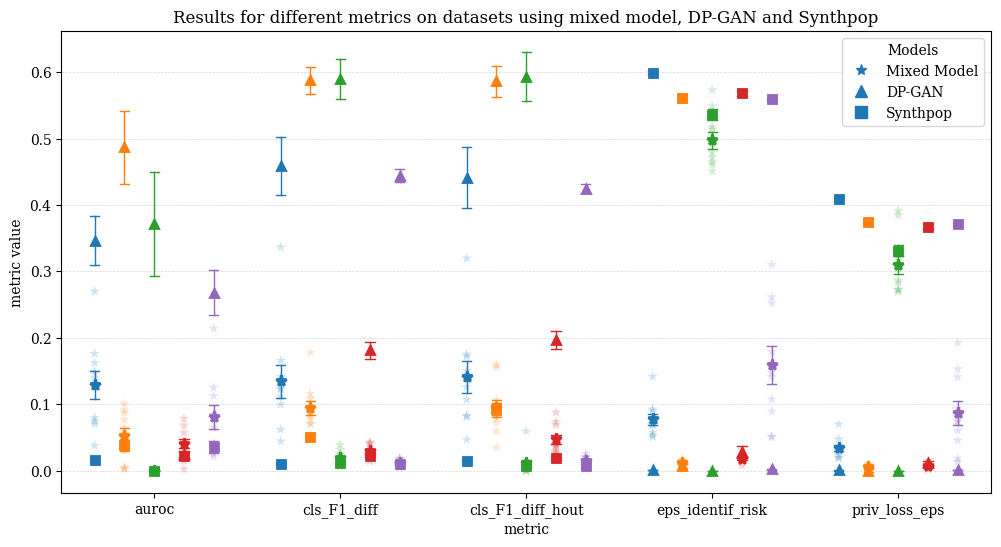

<Figure size 640x480 with 0 Axes>

In [46]:
from experiments.auxiliaries.plotting import make_relative_derviation_histogram

datasets = ['bc', 'cc', 'de', 'hp', 'st']
make_relative_derviation_histogram(datasets)